In [1]:
# Libraries.

import subprocess
import pandas as pd
import seaborn as sns
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mp
import operator
import scipy as sp
hot =  plt.get_cmap('hot')
plt.rcParams['svg.fonttype'] = 'none'

# Set some colors.
metric_ton_cols = [
    "#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800"]

# Define some functions.

def clusDicParser(clusDic, expr):
    exprDic = {}
    for cluster in clusDic:
        exprDic[cluster] = {}
        for factors in clusDic[cluster]:
            exprs = []
            hit = factors.split(' ')[1]
            # Fetch expression.
            if '::' in hit:
                for factor in hit.split('::'):
                    if factor.lower().capitalize() not in list(expr['symbol']):
                        print("{} not found, appending 0.".format(factor.lower().capitalize()))
                        exprs.append(float(0))
                    else:
                        exprs.append(np.mean(float(expr[expr['symbol'] == factor.lower().capitalize()]['baseMean']) ))
            elif '(' in hit:
                factor = hit.split('(')[0].lower().capitalize()
                if factor not in list(expr['symbol']):
                    print("{} not found, appending 0.".format(factor))
                    exprs.append(float(0))
                else:
                    exprs.append(float(np.mean(expr[expr['symbol'] == factor]['baseMean'])))
            else:
                factor = hit.lower().capitalize()
                if factor not in list(expr['symbol']):
                    print("{} not found, appending 0.".format(factor))
                    exprs.append(float(0))
                else:
                    exprs.append(float(np.mean(expr[expr['symbol'] == factor]['baseMean'])))
            exprDic[cluster][hit] = np.log10(np.mean(exprs) + 1)
    return exprDic
            
def matColFiller(exprDic, motifMat):
    '''
    exprDic = {Cluster_1:{hit:log10Expr, hit:log10Expr}, 
               Cluster_2:{hit:log10Expr, hit:log10Expr}}
    motitfMat index/cols (diss. matrix) = MA00000 SMAD1, MA00000 SMAD2
    '''
    # Get all txn factors in the matrix:
    txnFactors = list(motifMat.index)
    
    # get all txn factors in exprDic:
    expressedFactors = []
    for cluster in exprDic:
        for factor in exprDic[cluster]:
            expressedFactors.append(factor)
    '''
    clusDic containing the information for colors: cluster#, Representative factor & np.log10 expr.
    End goal:
    clusDic[factor] = [cluster# (str), clusterCol (hex), 
                       representative (bool), representative (hex),
                       np.log10 Expr (float), exprCol (hex)]
    '''
    # Start populating the coldic for output.
    
    clusDic = {}
    
    # colors per cluster - 
    for factor in txnFactors:
        # MA00000 SMAD1 -> SMAD1
        hit = factor.split(' ')[1]
        if hit not in expressedFactors:
            print("Mismatch between exprDic and matrix! Factor = {}".format(hit))
            break
        else:
        # Get all the factors in the exprDic
            for cluster in exprDic:
                if hit in exprDic[cluster]:
                    index_clus = int(cluster.split('_')[1]) - 1
                    clusDic[factor] = [cluster, metric_ton_cols[index_clus]]

    # Representatives.
    representatives = []
    repsDic = {}
    for cluster in exprDic:
        # Append the key (factor) of which the expr value is the highest.
        maxHit = max(exprDic[cluster].items(), key=operator.itemgetter(1))[0]
        if exprDic[cluster][maxHit] != 0:
            representatives.append(maxHit)
    for factor in txnFactors:
        hit = factor.split(' ')[1]
        if hit in representatives:
            clusDic[factor].append(True)
            clusDic[factor].append('#1f77b4')
        else:
            clusDic[factor].append(False)
            clusDic[factor].append('#ffffff')
    
    # add expression value into clusDF
    flatDic = {}
    for clus in exprDic:
        for factor in exprDic[clus]:
            flatDic[factor] = exprDic[clus][factor]
    
    for factor in txnFactors:
        hit = factor.split(' ')[1]
        expr = flatDic[hit]
        clusDic[factor].append(expr)
    
    clusDF = pd.DataFrame(clusDic)
    clusDF = clusDF.T
    clusDF.columns = ['Cluster', 'ClusterCol',
                      'Representative', 'repCol',
                      'Expression']
    # Finally map color to the expression value.
    exprs = sorted(set(list(clusDF['Expression'])))
    redMap = sns.color_palette("light:b", len(set(exprs)) )
    redDic = {}
    count = 0
    for expr in exprs:
        redDic[expr] = redMap[count]
        count += 1
    clusDF['ExprCol'] = clusDF['Expression'].map(redDic)
    return clusDF

def maxFromDic(dic):
    keyLis = ['0', 0]
    for i in dic:
        dicVal = dic[i]
        if dicVal > keyLis[1]:
            keyLis = [i, dic[i]]
    return keyLis


def renameClusMotMat(df, cond, repDic, dropLis = []):
    renameLis = []
    restCounter = 0
    for cluster in df.columns:
        if cluster in dropLis:
            df.drop(cluster, inplace=True, axis=1)
            df.drop(cluster, inplace=True, axis=0)
        else:
            if cond in cluster:
                if 'Cluster' in cluster:
                # get cluster number: "MPP3KO_Cluster_16 ATF4,CEBPA,CEBPB(...)"
                    clusName = '_'.join( cluster.split(' ')[0].split('_')[1:3])
                    if repDic[clusName] == 0: #No representative is expressed.
                        renameLis.append(cond + '_Unknown_' + clusName )
                    else:
                        renameLis.append(cond + '_' + repDic[clusName])
                else:
                    # Only 1 member in cluster: 'MPP4WT_MA1623.1 Stat2'
                    renameLis.append( cond + '_' + cluster.split(' ')[1] ) 
            else:
                # This motif is not in the 'target' condition, treating as NTC.
                restCounter += 1
                NTCcond = cluster.split('_')[0]
                renameLis.append(NTCcond + "_NTC_" + str(restCounter))
                #renameLis.append(cluster)
    df.columns = renameLis
    # Again for rows.
    restCounter = 0
    renameLis = []
    for cluster in df.index:
        if cond in cluster:
            if 'Cluster' in cluster:
            # get cluster number: "MPP3KO_Cluster_16 ATF4,CEBPA,CEBPB(...)"
                clusName = '_'.join( cluster.split(' ')[0].split('_')[1:3])
                if repDic[clusName] == 0: #No representative is expressed.
                    renameLis.append(cond + '_Unknown_' + clusName )
                else:
                    renameLis.append(cond + '_' + repDic[clusName])
            else:
                # Only 1 member in cluster: 'MPP4WT_MA1623.1 Stat2'
                renameLis.append( cond + '_' + cluster.split(' ')[1] ) 
        else:
            # This motif is not in the 'target' condition, treating as NTC.
            restCounter += 1
            NTCcond = cluster.split('_')[0]
            renameLis.append(NTCcond + "_NTC_" + str(restCounter))
            #renameLis.append(cluster)
    df.index = renameLis
    return df

In [2]:
# layout defs.
# Code from https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex2rgb(hexCol):
    hexCol = hexCol.replace('#','')
    hexLen = len(hexCol)
    return tuple ( int(hexCol[i:i + hexLen // 3], 16) for i in range(0, hexLen, hexLen // 3) )

def rgb2dec(tupe):
     return [v/256 for v in tupe]

    
def cmapFromHexLis(hexList):
    rgbLis = [rgb2dec( hex2rgb (i) ) for i in hexList ]
    #floats = list( np.linspace(0,1,len(rgbLis)) )
    #colDic = {}
    #for num, col in enumerate(['red', 'green','blue']):
    #    colList = [ [floats[i], rgbLis[i][num]] for i in range(len(floats)) ]
    #    colDic[col] = colList
    #print(colDic)
    cmp = mp.colors.LinearSegmentedColormap.from_list("CustomCol", rgbLis, N=256)
    return cmp

## Motifs [EBF_AL env]

ame (motif enrichments) are ran as part of the AOS workflow.

```bash
ame --o ../../data/ATAC/output/ame_MPP3_WT --control ../../data/ATAC/output/MPP3_KO.fna ../../data/ATAC/output/MPP3_WT.fna ../../LFS/genomeData/JASPAR_motifs.meme

ame --o ../../data/ATAC/output/ame_MPP3_KO --control ../../data/ATAC/output/MPP3_WT.fna ../../data/ATAC/output/MPP3_KO.fna ../../LFS/genomeData/JASPAR_motifs.meme

ame --o ../../data/ATAC/output/ame_MPP4_WT --control ../../data/ATAC/output/MPP4_KO.fna ../../data/ATAC/output/MPP4_WT.fna ../../LFS/genomeData/JASPAR_motifs.meme

ame --o ../../data/ATAC/output/ame_MPP4_KO --control ../../data/ATAC/output/MPP4_WT.fna ../../data/ATAC/output/MPP4_KO.fna ../../LFS/genomeData/JASPAR_motifs.meme
```

for MPP3 vs MPP4 (wt):

```bash
ame --o ../../data/ATAC_mpp3vmpp4/output/ame_MPP3 --control ../../data/ATAC_mpp3vmpp4/output/MPP4.fna ../../data/ATAC_mpp3vmpp4/output/MPP3.fna ../../LFS/genomeData/JASPAR_motifs.meme

ame --o ../../data/ATAC_mpp3vmpp4/output/ame_MPP4 --control ../../data/ATAC_mpp3vmpp4/output/MPP3.fna ../../data/ATAC_mpp3vmpp4/output/MPP4.fna ../../LFS/genomeData/JASPAR_motifs.meme
```

In [3]:
# Extract enriched motifs [EBF_AL env]

# MPP3 WT vs KO

# for 4 conditions.
conds = [
    'MPP3_KO',
    'MPP3_WT',
    'MPP4_KO',
    'MPP4_WT'
]
for cond in conds:
    extrCmd = [
        'python',
        '../../code/scripts/parseAMEresults.py',
        '--motifs',
        '../../LFS/genomeData/JASPAR_motifs.meme',
        '-i',
        '../../data/ATAC/output/ame_' + cond + '/ame.tsv',
        '-o',
        '../../data/ATAC/motifCluster/' + cond + '_hits.meme'
    ]
    retCode = subprocess.run(extrCmd)
    if retCode.returncode == 0:
        print("{} Extracted.".format(cond))


MPP3_KO Extracted.
MPP3_WT Extracted.
MPP4_KO Extracted.
MPP4_WT Extracted.


In [4]:
# MPP3 vs KO [EBF_AL env]

conds = [
    'MPP3',
    'MPP4'
]
for cond in conds:
    extrCmd = [
        'python',
        '../../code/scripts/parseAMEresults.py',
        '--motifs',
        '../../LFS/genomeData/JASPAR_motifs.meme',
        '-i',
        '../../data/ATAC_mpp3vmpp4/output/ame_' + cond + '/ame.tsv',
        '-o',
        '../../data/ATAC_mpp3vmpp4/motifCluster/' + cond + '_hits.meme'
    ]
    retCode = subprocess.run(extrCmd)
    if retCode.returncode == 0:
        print("{} Extracted".format(cond))

MPP3 Extracted
MPP4 Extracted


### Cluster motif hits: KO vs WT [TOBIASenv.yml]

```bash
TOBIAS ClusterMotifs -m ../../data/ATAC/motifCluster/MPP3_KO_hits.meme -t 0.4 --dist_method seqcor --clust_method complete -a meme -p MPP3_KO_clus -o ../../data/ATAC/motifCluster/MPP3_KO_clus -e png

TOBIAS ClusterMotifs -m ../../data/ATAC/motifCluster/MPP3_WT_hits.meme -t 0.4 --dist_method seqcor --clust_method complete -a meme -p MPP3_WT_clus -o ../../data/ATAC/motifCluster/MPP3_WT_clus -e png

TOBIAS ClusterMotifs -m ../../data/ATAC/motifCluster/MPP4_KO_hits.meme -t 0.4 --dist_method seqcor --clust_method complete -a meme -p MPP4_KO_clus -o ../../data/ATAC/motifCluster/MPP4_KO_clus -e png

TOBIAS ClusterMotifs -m ../../data/ATAC/motifCluster/MPP4_WT_hits.meme -t 0.4 --dist_method seqcor --clust_method complete -a meme -p MPP4_WT_clus -o ../../data/ATAC/motifCluster/MPP4_WT_clus -e png
```

### Cluster motif hits: MPP3 v MPP4 [TOBIASenv.yml]

```bash
TOBIAS ClusterMotifs -m ../../data/ATAC_mpp3vmpp4/motifCluster/MPP3_hits.meme -t 0.4 --dist_method seqcor --clust_method complete -a meme -p MPP3_clus -o ../../data/ATAC_mpp3vmpp4/motifCluster/MPP3_clus -e png

TOBIAS ClusterMotifs -m ../../data/ATAC_mpp3vmpp4/motifCluster/MPP4_hits.meme -t 0.4 --dist_method seqcor --clust_method complete -a meme -p MPP4_clus -o ../../data/ATAC_mpp3vmpp4/motifCluster/MPP4_clus -e png

```


### Rerun AME against consensus motifs : KO vs WT [EBF_AL env]

```bash
ame --o ../../data/ATAC/motifCluster/ameClus_MPP3WT --control --shuffle-- ../../data/ATAC/output/MPP3_WT.fna ../../data/ATAC/motifCluster/MPP3_WT_clus/MPP3_WT_clus_consensus_motifs.meme

ame --o ../../data/ATAC/motifCluster/ameClus_MPP3KO --control --shuffle-- ../../data/ATAC/output/MPP3_KO.fna ../../data/ATAC/motifCluster/MPP3_KO_clus/MPP3_KO_clus_consensus_motifs.meme

ame --o ../../data/ATAC/motifCluster/ameClus_MPP4WT --control --shuffle-- ../../data/ATAC/output/MPP4_WT.fna ../../data/ATAC/motifCluster/MPP4_WT_clus/MPP4_WT_clus_consensus_motifs.meme

ame --o ../../data/ATAC/motifCluster/ameClus_MPP4KO --control --shuffle-- ../../data/ATAC/output/MPP4_KO.fna ../../data/ATAC/motifCluster/MPP4_KO_clus/MPP4_KO_clus_consensus_motifs.meme
```

### Rerun AME against consensus motifs : MPP3 v MPP4 [EBF_AL env]

```bash
ame --o ../../data/ATAC_mpp3vmpp4/motifCluster/ameClus_MPP3 --control --shuffle-- ../../data/ATAC_mpp3vmpp4/output/MPP3.fna ../../data/ATAC_mpp3vmpp4/motifCluster/MPP3_clus/MPP3_clus_consensus_motifs.meme

ame --o ../../data/ATAC_mpp3vmpp4/motifCluster/ameClus_MPP4 --control --shuffle-- ../../data/ATAC_mpp3vmpp4/output/MPP4.fna ../../data/ATAC_mpp3vmpp4/motifCluster/MPP4_clus/MPP4_clus_consensus_motifs.meme
```

In [5]:
# Read in expression data.[EBF_AL env]
MPP3_RNA = pd.read_csv("../../data/RNA/MPP3_KOvsWT.tsv", index_col=0, sep='\t')
MPP4_RNA = pd.read_csv("../../data/RNA/MPP4_KOvsWT.tsv", index_col=0, sep='\t')


# Set columns
MPP3_RNA.columns = ['baseMean','log2FoldChange','lfcSE','pvalue','padj']
MPP4_RNA.columns = ['baseMean','log2FoldChange','lfcSE','pvalue','padj']

MPP3_RNA['symbol'] = MPP3_RNA.index
MPP4_RNA['symbol'] = MPP4_RNA.index


Elf3 not found, appending 0.
Elf5 not found, appending 0.
Etv1 not found, appending 0.
Etv4 not found, appending 0.
Zic2 not found, appending 0.
Znf317 not found, appending 0.
Znf341 not found, appending 0.
Atoh7 not found, appending 0.
Ascl2 not found, appending 0.
Atoh1 not found, appending 0.
Bhlha15 not found, appending 0.
Bhlha15 not found, appending 0.
Hand2 not found, appending 0.
Neurod1 not found, appending 0.
Neurog2 not found, appending 0.
Ptf1a not found, appending 0.
Twist1 not found, appending 0.
Ascl1 not found, appending 0.
Ascl1 not found, appending 0.
Bhlhe22 not found, appending 0.
Figla not found, appending 0.
Myf5 not found, appending 0.
Myod1 not found, appending 0.
Myog not found, appending 0.
Nhlh1 not found, appending 0.
Ptf1a not found, appending 0.
Ptf1a not found, appending 0.
Rbpjl not found, appending 0.
Snai1 not found, appending 0.
Snai2 not found, appending 0.
Snai3 not found, appending 0.
Tbx3 not found, appending 0.
Tbx5 not found, appending 0.
Hic1 n

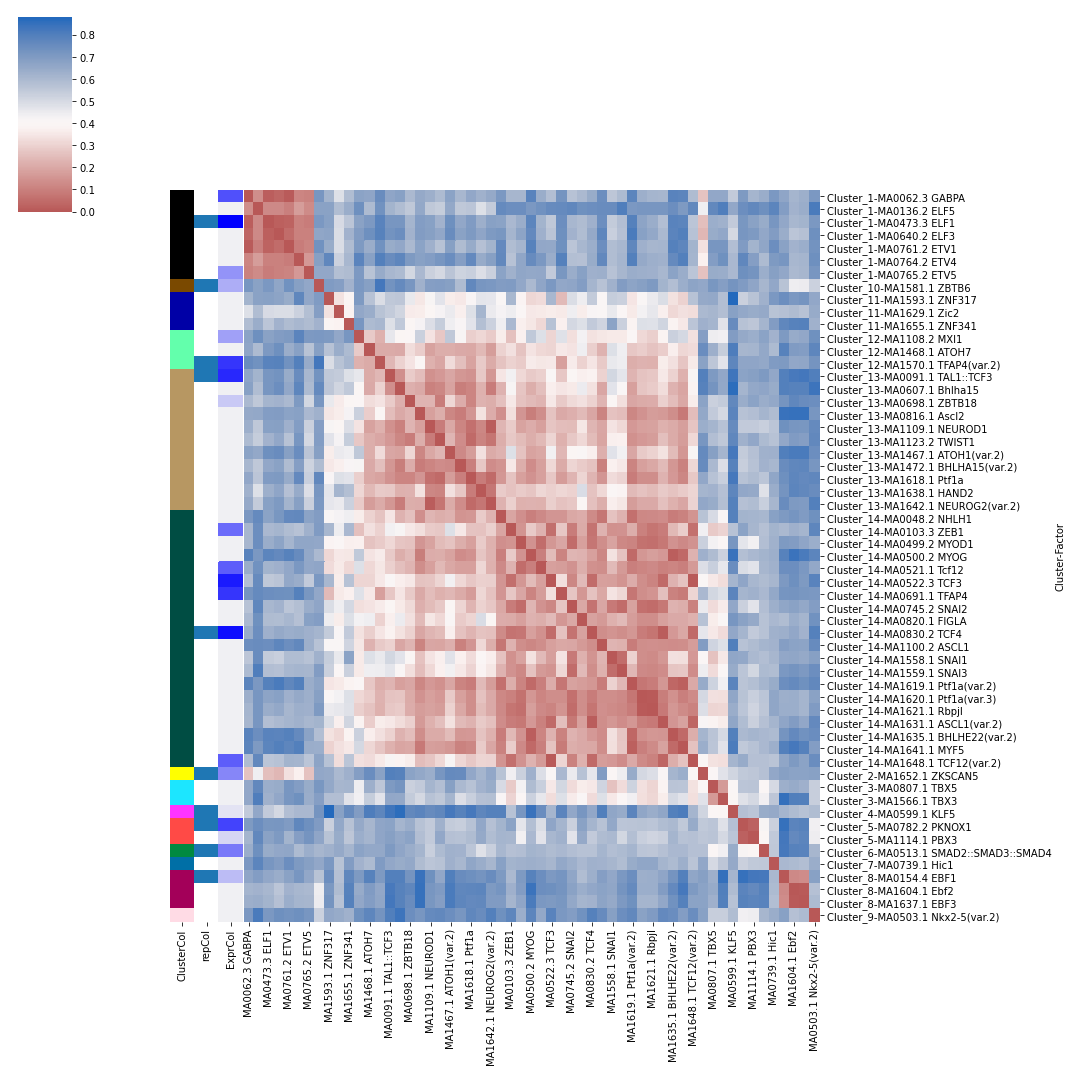

In [6]:
## MPP3 WT [EBF_AL env]

# Read up the clusterMotif YAML file (contains the information about what motifs are clustered together).
# Also read up the matrix file for plotting heatmaps.

with open('../../data/ATAC/motifCluster/MPP3_WT_clus/MPP3_WT_clus_clusters.yml') as f:
    MPP3_WTclus = yaml.safe_load(f)
MPP3WT_mat = pd.read_csv('../../data/ATAC/motifCluster/MPP3_WT_clus/MPP3_WT_clus_matrix.txt', sep='\t', index_col=0)
#Get expression per txnFactor
exprDic_MPP3WT = clusDicParser(MPP3_WTclus, MPP3_RNA)
colDic_MPP3WT = matColFiller(exprDic_MPP3WT, MPP3WT_mat)

rowNamTupe = []
for fac in MPP3WT_mat.index:
    foundStat = False
    for clus in MPP3_WTclus:
        if fac in MPP3_WTclus[clus]:
            rowNamTupe.append( (clus, fac) )
            foundStat = True

MPP3WT_mat_dupIx = MPP3WT_mat.copy()
MPP3WT_mat_dupIx.index = pd.MultiIndex.from_tuples(rowNamTupe, names=["Cluster", "Factor"])

# Change coldic index.
colMatTupes = []
for i in colDic_MPP3WT.index:
    for j in rowNamTupe:
        if j[1] == i:
            colMatTupes.append( (j[0], i) )
colDic_MPP3WT.index = pd.MultiIndex.from_tuples(colMatTupes, names=["Cluster", "Factor"])

colDic_MPP3WT = colDic_MPP3WT.sort_index(ascending=True)
MPP3WT_mat_dupIx = MPP3WT_mat_dupIx.sort_index(ascending=True)
colOrder = []
for i in MPP3WT_mat_dupIx.index:
    colOrder.append(i[1])
MPP3WT_mat_dupIx = MPP3WT_mat_dupIx[ colOrder ]


g = sns.clustermap(MPP3WT_mat_dupIx, center=0.4, method='complete',metric='correlation',
                 row_colors=colDic_MPP3WT[['ClusterCol','repCol','ExprCol']],
                 cmap='vlag_r', figsize=(15,15), row_cluster=False, col_cluster=False)

Foxh1 not found, appending 0.
Onecut1 not found, appending 0.
Neurod2 not found, appending 0.
Olig2 not found, appending 0.
Olig3 not found, appending 0.
Tcf21 not found, appending 0.
Creb5 not found, appending 0.
Jun(var.2) not found, appending 0.
Fosl1 not found, appending 0.
Jun(var.2) not found, appending 0.
Fosl1 not found, appending 0.
Jund(var.2) not found, appending 0.
Jund(var.2) not found, appending 0.
Junb(var.2) not found, appending 0.
Yy2 not found, appending 0.
Six1 not found, appending 0.
Six2 not found, appending 0.
Nkx2-8 not found, appending 0.
Nkx3-2 not found, appending 0.
Pax2 not found, appending 0.
Tead1 not found, appending 0.
Tead4 not found, appending 0.
Nfatc4 not found, appending 0.
Pou4f1 not found, appending 0.
Gsc2 not found, appending 0.
Otx2 not found, appending 0.
Pitx3 not found, appending 0.
Dlx1 not found, appending 0.
Pou6f1 not found, appending 0.


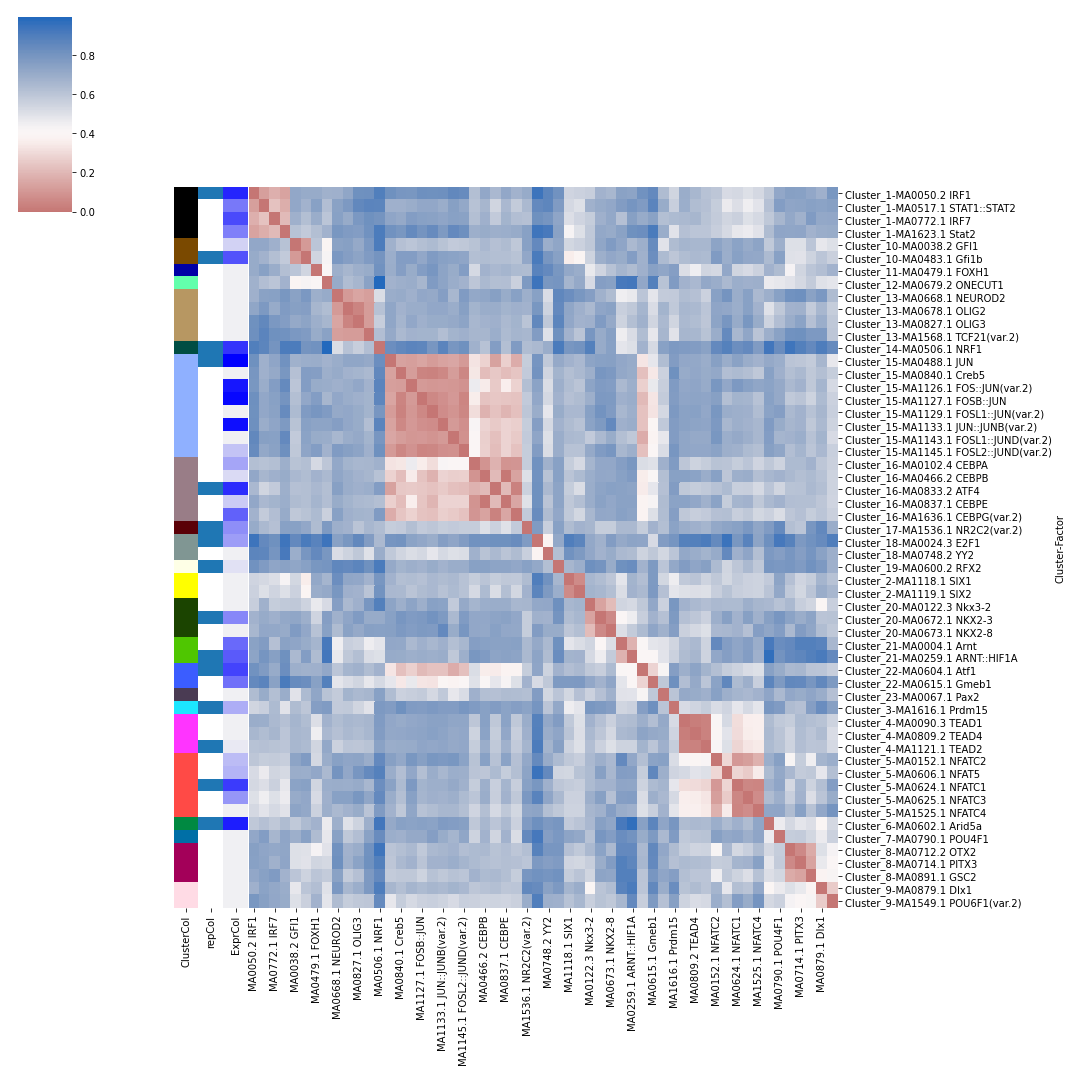

In [7]:
## MPP3 KO [EBF_AL env]

# Read up the clusterMotif YAML file (contains the information about what motifs are clustered together).
# Also read up the matrix file for plotting heatmaps.

with open('../../data/ATAC/motifCluster/MPP3_KO_clus/MPP3_KO_clus_clusters.yml') as f:
    MPP3_KOclus = yaml.safe_load(f)
MPP3KO_mat = pd.read_csv('../../data/ATAC/motifCluster/MPP3_KO_clus/MPP3_KO_clus_matrix.txt', sep='\t', index_col=0)
#Get expression per txnFactor
exprDic_MPP3KO = clusDicParser(MPP3_KOclus, MPP3_RNA)
colDic_MPP3KO = matColFiller(exprDic_MPP3KO, MPP3KO_mat)

rowNamTupe = []
for fac in MPP3KO_mat.index:
    foundStat = False
    for clus in MPP3_KOclus:
        if fac in MPP3_KOclus[clus]:
            rowNamTupe.append( (clus, fac) )
            foundStat = True

MPP3KO_mat_dupIx = MPP3KO_mat.copy()
MPP3KO_mat_dupIx.index = pd.MultiIndex.from_tuples(rowNamTupe, names=["Cluster", "Factor"])

# Change coldic index.
colMatTupes = []
for i in colDic_MPP3KO.index:
    for j in rowNamTupe:
        if j[1] == i:
            colMatTupes.append( (j[0], i) )
colDic_MPP3KO.index = pd.MultiIndex.from_tuples(colMatTupes, names=["Cluster", "Factor"])

colDic_MPP3KO = colDic_MPP3KO.sort_index(ascending=True)
MPP3KO_mat_dupIx = MPP3KO_mat_dupIx.sort_index(ascending=True)
colOrder = []
for i in MPP3KO_mat_dupIx.index:
    colOrder.append(i[1])
MPP3KO_mat_dupIx = MPP3KO_mat_dupIx[ colOrder ]


g = sns.clustermap(MPP3KO_mat_dupIx, center=0.4, method='complete',metric='correlation',
                 row_colors=colDic_MPP3KO[['ClusterCol','repCol','ExprCol']],
                 cmap='vlag_r', figsize=(15,15), row_cluster=False, col_cluster=False)

In [8]:
# Get the representatives: [EBF_AL env]
print("MPP3 KO:")
for cluster in exprDic_MPP3KO:
    print("Cluster: {} has representative: {} {}".format(cluster, 
                                                         maxFromDic(exprDic_MPP3KO[cluster])[0],
                                                         maxFromDic(exprDic_MPP3KO[cluster])[1])
         )

MPP3 KO:
Cluster: Cluster_1 has representative: IRF1 3.644838622802023
Cluster: Cluster_10 has representative: Gfi1b 3.2925025413208187
Cluster: Cluster_11 has representative: 0 0
Cluster: Cluster_12 has representative: 0 0
Cluster: Cluster_13 has representative: 0 0
Cluster: Cluster_14 has representative: NRF1 3.5498969470475306
Cluster: Cluster_15 has representative: JUN 4.529718232697127
Cluster: Cluster_16 has representative: ATF4 3.5644928920432974
Cluster: Cluster_17 has representative: NR2C2(var.2) 2.977257304708071
Cluster: Cluster_18 has representative: E2F1 2.9463072378470403
Cluster: Cluster_19 has representative: RFX2 2.4211952342481875
Cluster: Cluster_2 has representative: 0 0
Cluster: Cluster_20 has representative: NKX2-3 3.0481508092979044
Cluster: Cluster_21 has representative: ARNT::HIF1A 3.2883330568733222
Cluster: Cluster_22 has representative: Atf1 3.3115490451211738
Cluster: Cluster_23 has representative: 0 0
Cluster: Cluster_3 has representative: Prdm15 2.7520228

Znf384 not found, appending 0.
Foxa1 not found, appending 0.
Foxa2 not found, appending 0.
Foxa3 not found, appending 0.
Foxb1 not found, appending 0.
Foxc1 not found, appending 0.
Foxc2 not found, appending 0.
Foxd1 not found, appending 0.
Foxd2 not found, appending 0.
Foxe1 not found, appending 0.
Foxf1 not found, appending 0.
Foxf2 not found, appending 0.
Foxg1 not found, appending 0.
Foxh1 not found, appending 0.
Foxi1 not found, appending 0.
Foxl1 not found, appending 0.
Foxl2 not found, appending 0.
Foxo6 not found, appending 0.
Foxp2 not found, appending 0.
Foxq1 not found, appending 0.
Foxd3 not found, appending 0.
Foxp3 not found, appending 0.
Sox15 not found, appending 0.
Sox8 not found, appending 0.
Sry not found, appending 0.
Pou1f1 not found, appending 0.
Pou3f1 not found, appending 0.
Pou3f2 not found, appending 0.
Pou3f3 not found, appending 0.
Pou5f1 not found, appending 0.
Pou5f1b not found, appending 0.
Cdx2 not found, appending 0.
Hoxb13 not found, appending 0.
Meis2

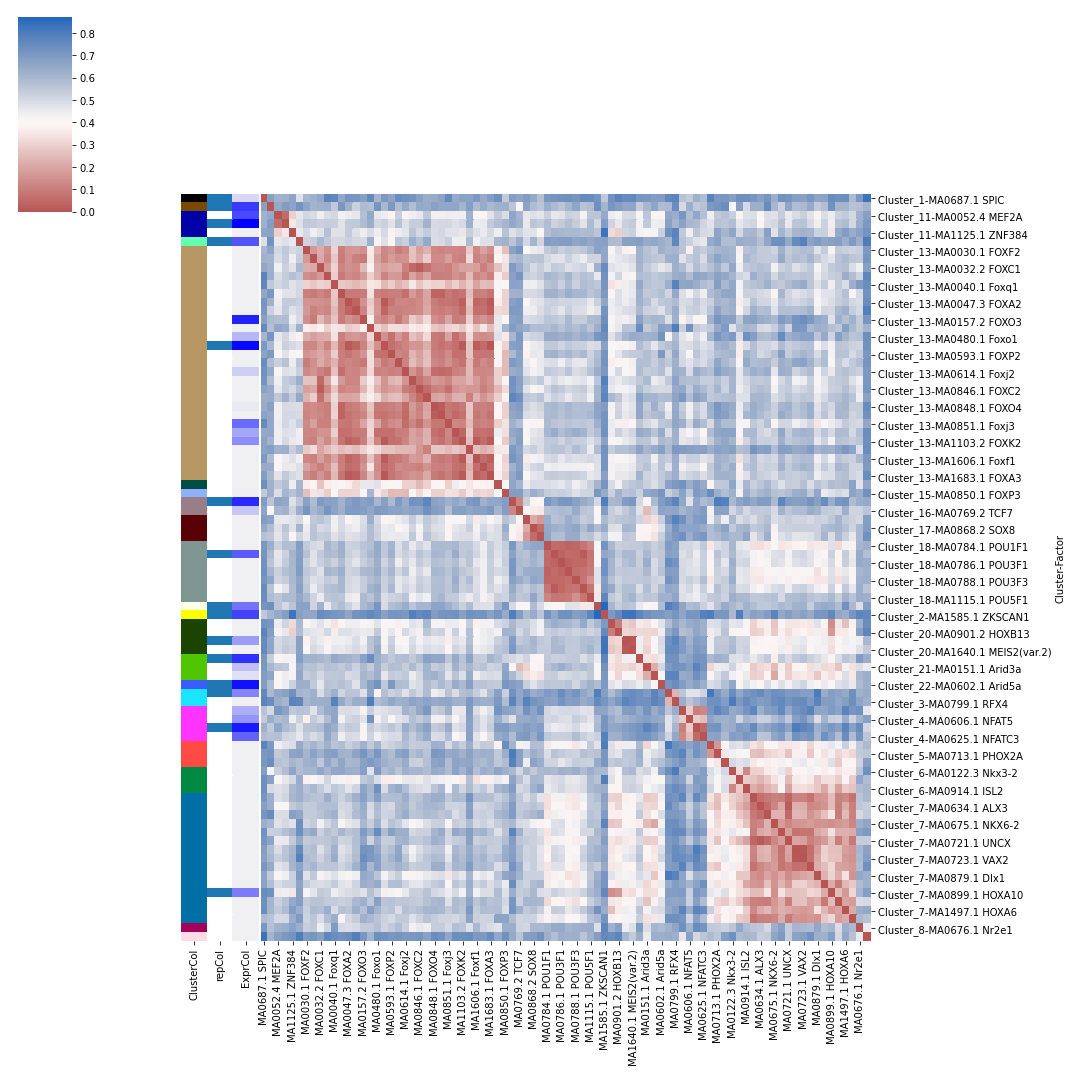

In [9]:
## MPP4 WT [EBF_AL env]

# Read up the clusterMotif YAML file (contains the information about what motifs are clustered together).
# Also read up the matrix file for plotting heatmaps.

with open('../../data/ATAC/motifCluster/MPP4_WT_clus/MPP4_WT_clus_clusters.yml') as f:
    MPP4_WTclus = yaml.safe_load(f)
MPP4WT_mat = pd.read_csv('../../data/ATAC/motifCluster/MPP4_WT_clus/MPP4_WT_clus_matrix.txt', sep='\t', index_col=0)
#Get expression per txnFactor
exprDic_MPP4WT = clusDicParser(MPP4_WTclus, MPP4_RNA)
colDic_MPP4WT = matColFiller(exprDic_MPP4WT, MPP4WT_mat)

rowNamTupe = []
for fac in MPP4WT_mat.index:
    foundStat = False
    for clus in MPP4_WTclus:
        if fac in MPP4_WTclus[clus]:
            rowNamTupe.append( (clus, fac) )
            foundStat = True

MPP4WT_mat_dupIx = MPP4WT_mat.copy()
MPP4WT_mat_dupIx.index = pd.MultiIndex.from_tuples(rowNamTupe, names=["Cluster", "Factor"])

# Change coldic index.
colMatTupes = []
for i in colDic_MPP4WT.index:
    for j in rowNamTupe:
        if j[1] == i:
            colMatTupes.append( (j[0], i) )
colDic_MPP4WT.index = pd.MultiIndex.from_tuples(colMatTupes, names=["Cluster", "Factor"])

colDic_MPP4WT = colDic_MPP4WT.sort_index(ascending=True)
MPP4WT_mat_dupIx = MPP4WT_mat_dupIx.sort_index(ascending=True)
colOrder = []
for i in MPP4WT_mat_dupIx.index:
    colOrder.append(i[1])
MPP4WT_mat_dupIx = MPP4WT_mat_dupIx[ colOrder ]

g = sns.clustermap(MPP4WT_mat_dupIx, center=0.4, method='complete',metric='correlation',
                 row_colors=colDic_MPP4WT[['ClusterCol','repCol','ExprCol']],
                 cmap='vlag_r', figsize=(15,15), row_cluster=False, col_cluster=False)

In [10]:
# Get the representatives: [EBF_AL env]
print("MPP4 WT:")
for cluster in exprDic_MPP4WT:
    print("Cluster: {} has representative: {} {}".format(cluster, 
                                                         maxFromDic(exprDic_MPP4WT[cluster])[0],
                                                         maxFromDic(exprDic_MPP4WT[cluster])[1])
         )

MPP4 WT:
Cluster: Cluster_1 has representative: SPIC 2.2817614556352708
Cluster: Cluster_10 has representative: HLTF 3.3622797104192244
Cluster: Cluster_11 has representative: MEF2C 4.146201674787359
Cluster: Cluster_12 has representative: Stat2 3.127489771850295
Cluster: Cluster_13 has representative: FOXP1 4.002741543503638
Cluster: Cluster_14 has representative: 0 0
Cluster: Cluster_15 has representative: 0 0
Cluster: Cluster_16 has representative: TCF7L2 3.460213429028051
Cluster: Cluster_17 has representative: 0 0
Cluster: Cluster_18 has representative: POU2F1 2.982561667122311
Cluster: Cluster_19 has representative: LIN54 2.9304389634362806
Cluster: Cluster_2 has representative: ZKSCAN1 3.2383364022411336
Cluster: Cluster_20 has representative: PBX2 2.67695685091653
Cluster: Cluster_21 has representative: TBP 3.4571814620403374
Cluster: Cluster_22 has representative: Arid5a 3.6811598547448585
Cluster: Cluster_3 has representative: RFX1 2.8220493481491498
Cluster: Cluster_4 has re

Ascl1 not found, appending 0.
Ascl1 not found, appending 0.
Myod1 not found, appending 0.
Nhlh1 not found, appending 0.
Ptf1a not found, appending 0.
Rbpjl not found, appending 0.
Snai1 not found, appending 0.
Snai2 not found, appending 0.
Snai3 not found, appending 0.
Tcfl5 not found, appending 0.
Tfap2a not found, appending 0.
Tfap2b not found, appending 0.
Tfap2c not found, appending 0.
Ctcfl not found, appending 0.
Klf15 not found, appending 0.
Znf148 not found, appending 0.
Wt1 not found, appending 0.
Sp9 not found, appending 0.
Znf263 not found, appending 0.


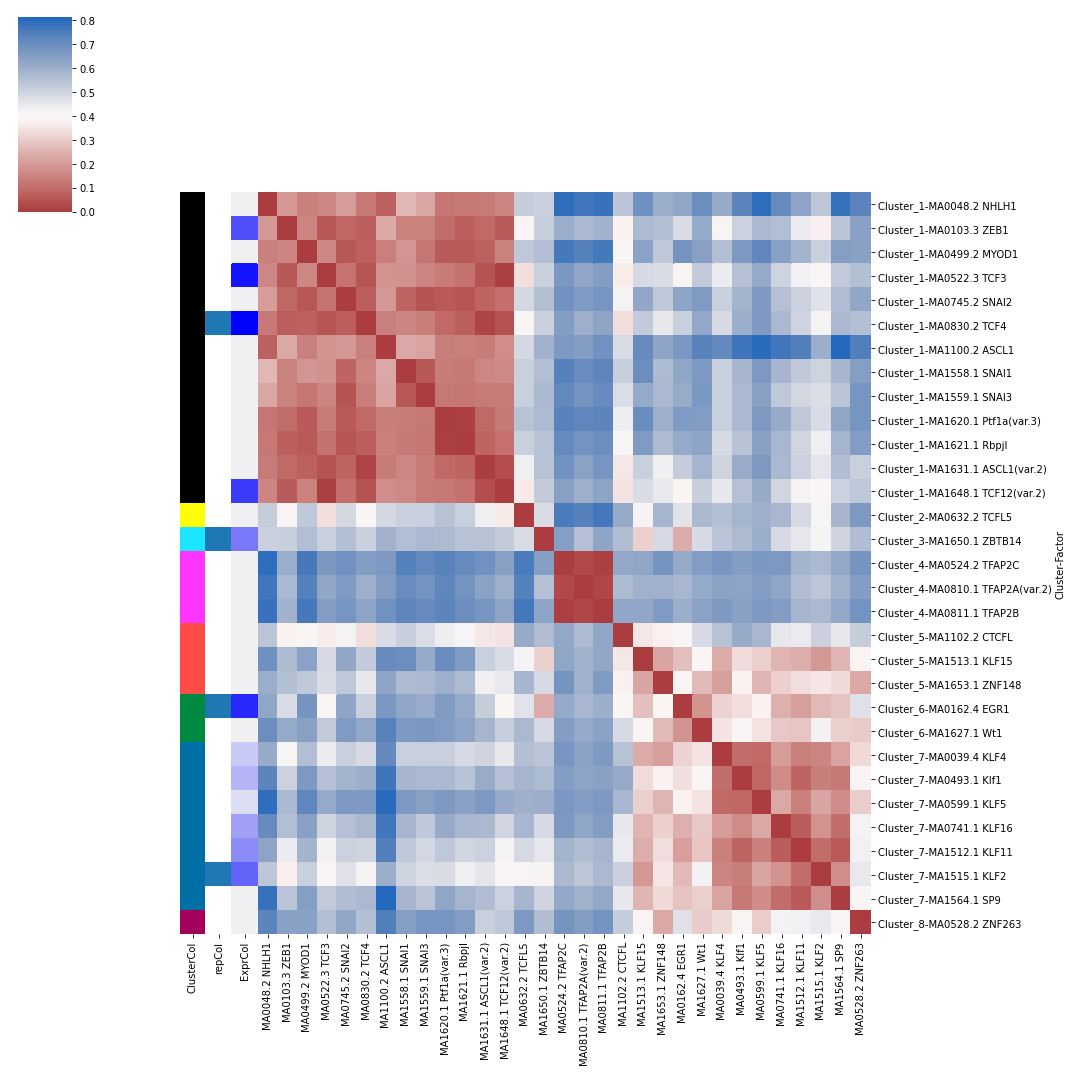

In [11]:
## MPP4 KO [EBF_AL env]
 
# Read up the clusterMotif YAML file (contains the information about what motifs are clustered together).
# Also read up the matrix file for plotting heatmaps.

with open('../../data/ATAC/motifCluster/MPP4_KO_clus/MPP4_KO_clus_clusters.yml') as f:
    MPP4_KOclus = yaml.safe_load(f)
MPP4KO_mat = pd.read_csv('../../data/ATAC/motifCluster/MPP4_KO_clus/MPP4_KO_clus_matrix.txt', sep='\t', index_col=0)
#Get expression per txnFactor
exprDic_MPP4KO = clusDicParser(MPP4_KOclus, MPP4_RNA)
colDic_MPP4KO = matColFiller(exprDic_MPP4KO, MPP4KO_mat)

rowNamTupe = []
for fac in MPP4KO_mat.index:
    foundStat = False
    for clus in MPP4_KOclus:
        if fac in MPP4_KOclus[clus]:
            rowNamTupe.append( (clus, fac) )
            foundStat = True

MPP4KO_mat_dupIx = MPP4KO_mat.copy()
MPP4KO_mat_dupIx.index = pd.MultiIndex.from_tuples(rowNamTupe, names=["Cluster", "Factor"])

# Change coldic index.
colMatTupes = []
for i in colDic_MPP4KO.index:
    for j in rowNamTupe:
        if j[1] == i:
            colMatTupes.append( (j[0], i) )
colDic_MPP4KO.index = pd.MultiIndex.from_tuples(colMatTupes, names=["Cluster", "Factor"])

colDic_MPP4KO = colDic_MPP4KO.sort_index(ascending=True)
MPP4KO_mat_dupIx = MPP4KO_mat_dupIx.sort_index(ascending=True)
colOrder = []
for i in MPP4KO_mat_dupIx.index:
    colOrder.append(i[1])
MPP4KO_mat_dupIx = MPP4KO_mat_dupIx[ colOrder ]


g = sns.clustermap(MPP4KO_mat_dupIx, center=0.4, method='complete',metric='correlation',
                 row_colors=colDic_MPP4KO[['ClusterCol','repCol','ExprCol']],
                 cmap='vlag_r', figsize=(15,15), row_cluster=False, col_cluster=False)

In [12]:
# Get the representatives: [EBF_AL env]
print("MPP4 KO:")
for cluster in exprDic_MPP4KO:
    print("Cluster: {} has representative: {} {}".format(cluster, 
                                                         maxFromDic(exprDic_MPP4KO[cluster])[0],
                                                         maxFromDic(exprDic_MPP4KO[cluster])[1])
         )

MPP4 KO:
Cluster: Cluster_1 has representative: TCF4 3.9188816376791045
Cluster: Cluster_2 has representative: 0 0
Cluster: Cluster_3 has representative: ZBTB14 3.178552269676703
Cluster: Cluster_4 has representative: 0 0
Cluster: Cluster_5 has representative: 0 0
Cluster: Cluster_6 has representative: EGR1 3.4010358715540407
Cluster: Cluster_7 has representative: KLF2 3.20392856011995
Cluster: Cluster_8 has representative: 0 0


### MPP3 vs MPP4

Arnt2 not found, appending 0.
Bhlhe41 not found, appending 0.
Mlxipl not found, appending 0.
Hes2 not found, appending 0.
Hey1 not found, appending 0.
Hey2 not found, appending 0.
Sohlh2 not found, appending 0.
Tcfl5 not found, appending 0.
Yy2 not found, appending 0.
Zfp42 not found, appending 0.
Pax1 not found, appending 0.
Pax5 not found, appending 0.
Pax9 not found, appending 0.
Pax2 not found, appending 0.
Ovol2 not found, appending 0.
Sox18 not found, appending 0.
Pou3f4 not found, appending 0.
Pou5f1b not found, appending 0.
Fev not found, appending 0.
Tfap2a not found, appending 0.
Tfap2b not found, appending 0.
Tfap2c not found, appending 0.
Ebf2 not found, appending 0.
Ebf3 not found, appending 0.
Tfap2a not found, appending 0.
Tfap2a not found, appending 0.
Tfap2b not found, appending 0.
Tfap2b not found, appending 0.
Tfap2c not found, appending 0.
Tfap2c not found, appending 0.
Tfap2e not found, appending 0.
Plag1 not found, appending 0.
Klf14 not found, appending 0.
Sp8 no

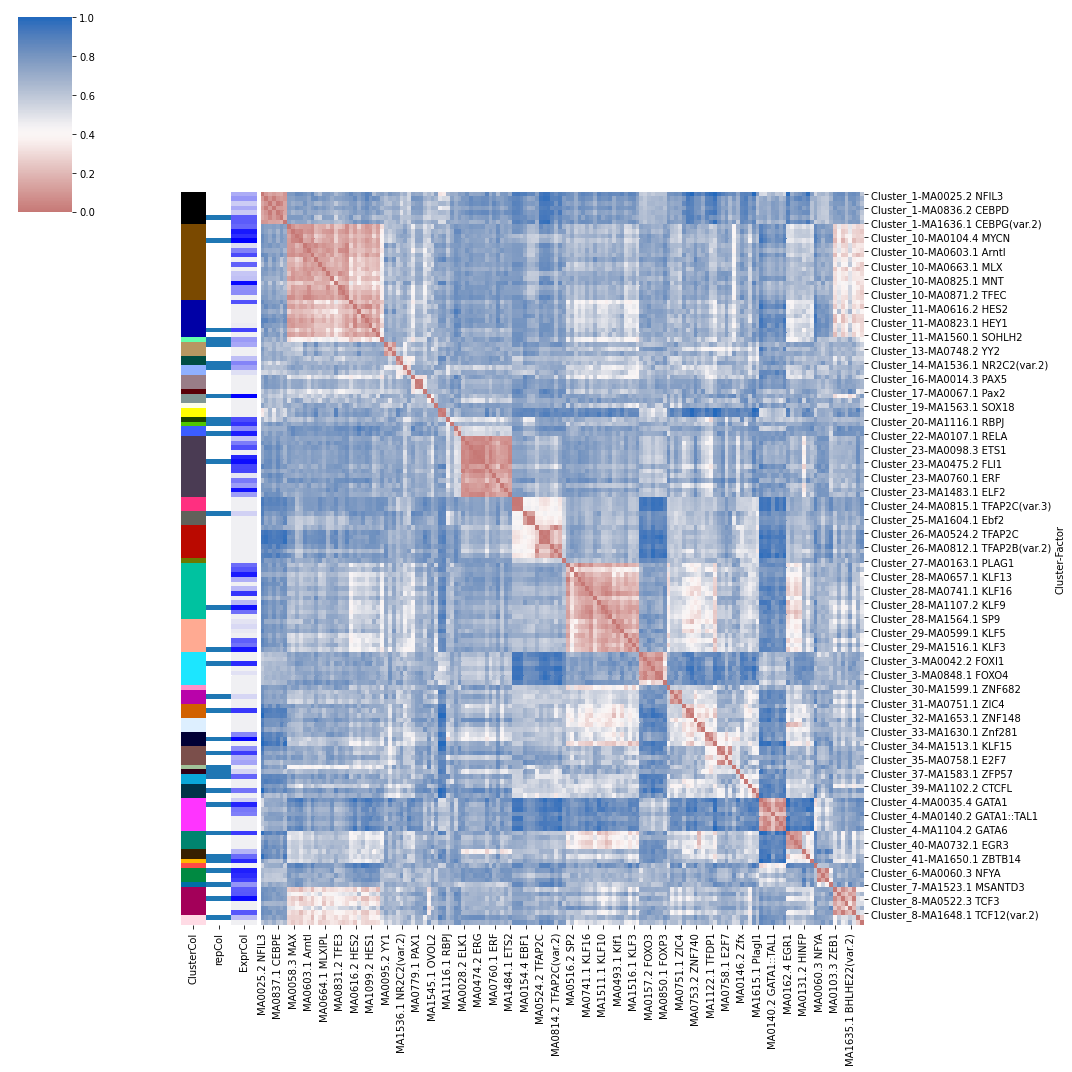

In [13]:
## MPP3 [EBF_AL env]

# Read up the clusterMotif YAML file (contains the information about what motifs are clustered together).
# Also read up the matrix file for plotting heatmaps.

with open('../../data/ATAC_mpp3vmpp4/motifCluster/MPP3_clus/MPP3_clus_clusters.yml') as f:
    MPP3_clus = yaml.safe_load(f)
MPP3_mat = pd.read_csv('../../data/ATAC_mpp3vmpp4/motifCluster/MPP3_clus/MPP3_clus_matrix.txt',
                       sep='\t', index_col=0)
#Get expression per txnFactor
exprDic_MPP3 = clusDicParser(MPP3_clus, MPP3_RNA)
colDic_MPP3 = matColFiller(exprDic_MPP3, MPP3_mat)

rowNamTupe = []
for fac in MPP3_mat.index:
    foundStat = False
    for clus in MPP3_clus:
        if fac in MPP3_clus[clus]:
            rowNamTupe.append( (clus, fac) )
            foundStat = True

MPP3_mat_dupIx = MPP3_mat.copy()
MPP3_mat_dupIx.index = pd.MultiIndex.from_tuples(rowNamTupe, names=["Cluster", "Factor"])

# Change coldic index.
colMatTupes = []
for i in colDic_MPP3.index:
    for j in rowNamTupe:
        if j[1] == i:
            colMatTupes.append( (j[0], i) )
colDic_MPP3.index = pd.MultiIndex.from_tuples(colMatTupes, names=["Cluster", "Factor"])

colDic_MPP3 = colDic_MPP3.sort_index(ascending=True)
MPP3_mat_dupIx = MPP3_mat_dupIx.sort_index(ascending=True)
colOrder = []
for i in MPP3_mat_dupIx.index:
    colOrder.append(i[1])
MPP3_mat_dupIx = MPP3_mat_dupIx[ colOrder ]


g = sns.clustermap(MPP3_mat_dupIx, center=0.4, method='complete',metric='correlation',
                 row_colors=colDic_MPP3[['ClusterCol','repCol','ExprCol']],
                 cmap='vlag_r', figsize=(15,15), row_cluster=False, col_cluster=False)

In [14]:
# Get the representatives: [EBF_AL env]
print("MPP3:")
for cluster in exprDic_MPP3:
    print("Cluster: {} has representative: {} {}".format(cluster, 
                                                         maxFromDic(exprDic_MPP3[cluster])[0],
                                                         maxFromDic(exprDic_MPP3[cluster])[1])
         )

MPP3:
Cluster: Cluster_1 has representative: CEBPG 3.21215721059102
Cluster: Cluster_10 has representative: MYC 4.5697454014860375
Cluster: Cluster_11 has representative: HIF1A 3.3741369421175382
Cluster: Cluster_12 has representative: Ahr::Arnt 2.9247874680804524
Cluster: Cluster_13 has representative: YY1 2.8412738548836214
Cluster: Cluster_14 has representative: NR2C2(var.2) 2.977257304708071
Cluster: Cluster_15 has representative: THAP1 2.8744832549831383
Cluster: Cluster_16 has representative: 0 0
Cluster: Cluster_17 has representative: 0 0
Cluster: Cluster_18 has representative: MYB 4.0236141010399455
Cluster: Cluster_19 has representative: 0 0
Cluster: Cluster_2 has representative: 0 0
Cluster: Cluster_20 has representative: RBPJ 3.3182406923202223
Cluster: Cluster_21 has representative: THAP11 3.460901127956834
Cluster: Cluster_22 has representative: RELA 3.685250414110056
Cluster: Cluster_23 has representative: FLI1 3.824898292977163
Cluster: Cluster_24 has representative: 0 0

Foxa1 not found, appending 0.
Foxa2 not found, appending 0.
Foxa3 not found, appending 0.
Foxb1 not found, appending 0.
Foxc1 not found, appending 0.
Foxc2 not found, appending 0.
Foxd1 not found, appending 0.
Foxd2 not found, appending 0.
Foxf1 not found, appending 0.
Foxh1 not found, appending 0.
Foxi1 not found, appending 0.
Foxl1 not found, appending 0.
Foxl2 not found, appending 0.
Foxp2 not found, appending 0.
Foxq1 not found, appending 0.
Nr2e3 not found, appending 0.
Nr1i3 not found, appending 0.
Rorb not found, appending 0.
Rorc not found, appending 0.
Nr2e1 not found, appending 0.
Nfatc4 not found, appending 0.
Sox10 not found, appending 0.
Sox15 not found, appending 0.
Sox17 not found, appending 0.
Sox2 not found, appending 0.
Sox3 not found, appending 0.
Sox8 not found, appending 0.
Foxd3 not found, appending 0.
Sox9 not found, appending 0.
Sry not found, appending 0.
Cdx1 not found, appending 0.
Cdx2 not found, appending 0.
Cdx4 not found, appending 0.
Hoxa13 not found, ap

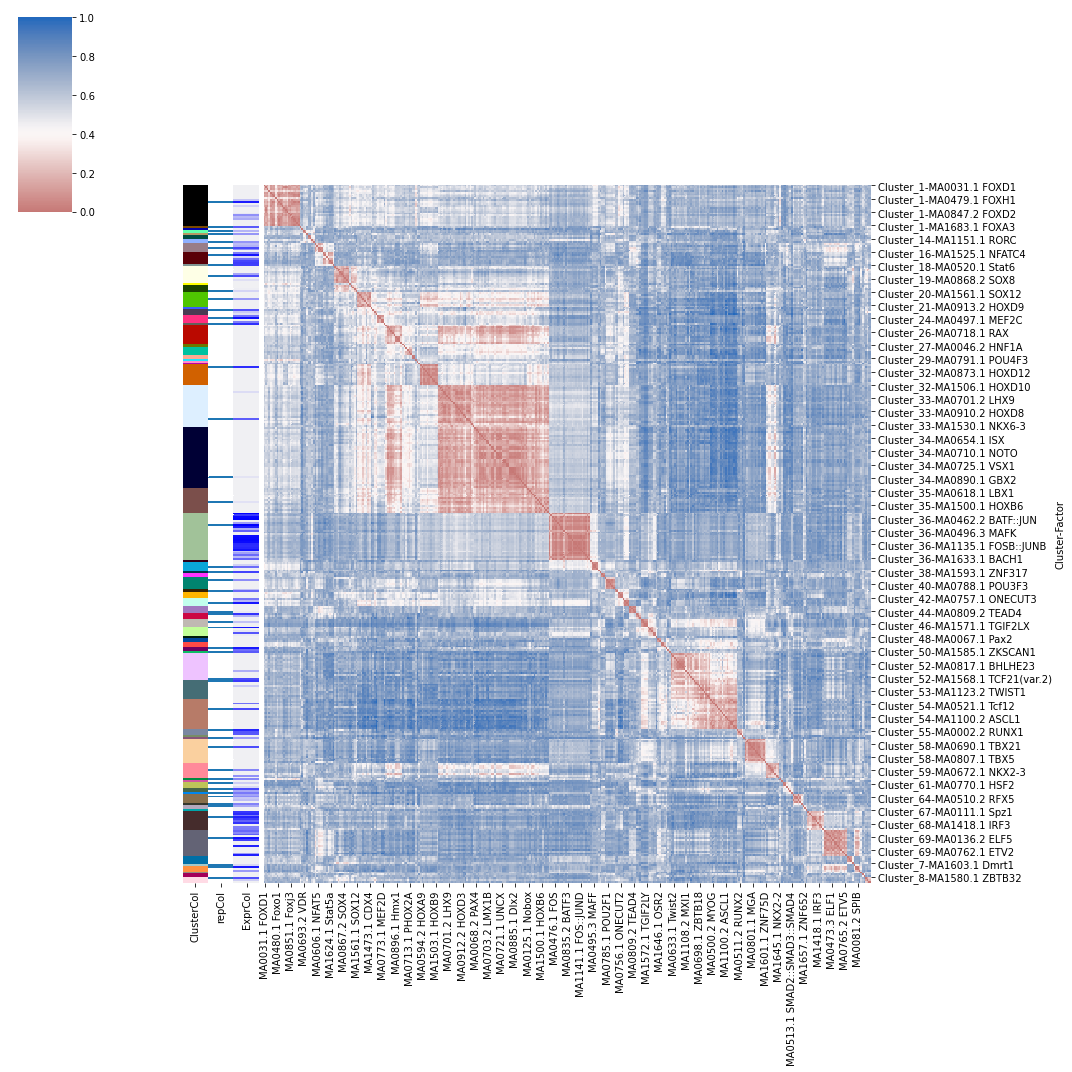

In [15]:
## MPP4 [EBF_AL env]

# Read up the clusterMotif YAML file (contains the information about what motifs are clustered together).
# Also read up the matrix file for plotting heatmaps.

with open('../../data/ATAC_mpp3vmpp4/motifCluster/MPP4_clus/MPP4_clus_clusters.yml') as f:
    MPP4_clus = yaml.safe_load(f)
MPP4_mat = pd.read_csv('../../data/ATAC_mpp3vmpp4/motifCluster/MPP4_clus/MPP4_clus_matrix.txt',
                       sep='\t', index_col=0)
#Get expression per txnFactor
exprDic_MPP4 = clusDicParser(MPP4_clus, MPP4_RNA)
colDic_MPP4 = matColFiller(exprDic_MPP4, MPP4_mat)

rowNamTupe = []
for fac in MPP4_mat.index:
    foundStat = False
    for clus in MPP4_clus:
        if fac in MPP4_clus[clus]:
            rowNamTupe.append( (clus, fac) )
            foundStat = True

MPP4_mat_dupIx = MPP4_mat.copy()
MPP4_mat_dupIx.index = pd.MultiIndex.from_tuples(rowNamTupe, names=["Cluster", "Factor"])

# Change coldic index.
colMatTupes = []
for i in colDic_MPP4.index:
    for j in rowNamTupe:
        if j[1] == i:
            colMatTupes.append( (j[0], i) )
colDic_MPP4.index = pd.MultiIndex.from_tuples(colMatTupes, names=["Cluster", "Factor"])

colDic_MPP4 = colDic_MPP4.sort_index(ascending=True)
MPP4_mat_dupIx = MPP4_mat_dupIx.sort_index(ascending=True)
colOrder = []
for i in MPP4_mat_dupIx.index:
    colOrder.append(i[1])
MPP4_mat_dupIx = MPP4_mat_dupIx[ colOrder ]


g = sns.clustermap(MPP4_mat_dupIx, center=0.4, method='complete',metric='correlation',
                 row_colors=colDic_MPP4[['ClusterCol','repCol','ExprCol']],
                 cmap='vlag_r', figsize=(15,15), row_cluster=False, col_cluster=False)

### Comotifs.

To see which motifs are 'acting together' we count how many times they co-occur. To this extent the cluster representatives are combined (data/ATAC/coMotifEnrichment/enrichedMots.meme). The Z-scores are calculated for every specific peakset, using the full peaks as background.

The combined conditionally enriched motif clusters are clustered again to have one non-redundant set of motif representatives.

#### KO vs WT
[TOBIAS env]
```bash
TOBIAS ClusterMotifs -m ../../data/ATAC/coMotifEnrichment/enrichedMots.meme -t 0.4 --dist_method seqcor --clust_method complete -a meme -p enrichedMots -o ../../data/ATAC/coMotifEnrichment/enrichedMots_cluster -e png
```

[EBF_AL env]
```bash

cd ../../data/ATAC/coMotifEnrichment

python ../../../code/scripts/coMotifs.py --iBed ../output/MPP3_WT.bed --bgBed ../output/MPP3_peaks.bed --motifs enrichedMots_cluster/enrichedMots_consensus_motifs.meme --fasta ../../../LFS/genomeData/genome.fa --reps 1000 --threads 5 --tmpdir /data/extended/ --prefix MPP3WT_allMots

python ../../../code/scripts/coMotifs.py --iBed ../output/MPP3_KO.bed --bgBed ../output/MPP3_peaks.bed --motifs enrichedMots_cluster/enrichedMots_consensus_motifs.meme --fasta ../../../LFS/genomeData/genome.fa --reps 1000 --threads 5 --tmpdir /data/extended/ --prefix MPP3KO_allMots

python ../../../code/scripts/coMotifs.py --iBed ../output/MPP4_WT.bed --bgBed ../output/MPP4_peaks.bed --motifs enrichedMots_cluster/enrichedMots_consensus_motifs.meme --fasta ../../../LFS/genomeData/genome.fa --reps 1000 --threads 5 --tmpdir /data/extended/ --prefix MPP4WT_allMots

python ../../../code/scripts/coMotifs.py --iBed ../output/MPP4_KO.bed --bgBed ../output/MPP4_peaks.bed --motifs enrichedMots_cluster/enrichedMots_consensus_motifs.meme --fasta ../../../LFS/genomeData/genome.fa --reps 1000 --threads 5 --tmpdir /data/extended/ --prefix MPP4KO_allMots

```
[TOBIAS env]
#### MPP3 vs MPP4

```bash
TOBIAS ClusterMotifs -m ../../data/ATAC_mpp3vmpp4/coMotifEnrichment/enrichedMots.meme -t 0.4 --dist_method seqcor --clust_method complete -a meme -p enrichedMots -o ../../data/ATAC_mpp3vmpp4/coMotifEnrichment/enrichedMots_cluster -e png
```
[EBF_AL env]
```bash
python ../../../code/scripts/coMotifs.py --iBed ../output/MPP3.bed --bgBed ../../ATAC/output/MPP3_peaks.bed --motifs enrichedMots_cluster/enrichedMots_consensus_motifs.meme --fasta ../../../LFS/genomeData/genome.fa --reps 1000 --threads 5 --tmpdir /data/extended --prefix MPP3_allMots

python ../../../code/scripts/coMotifs.py --iBed ../output/MPP4.bed --bgBed ../../ATAC/output/MPP3_peaks.bed --motifs enrichedMots_cluster/enrichedMots_consensus_motifs.meme --fasta ../../../LFS/genomeData/genome.fa --reps 1000 --threads 5 --tmpdir /data/extended --prefix MPP4_allMots
```



In [16]:
# Create function to rename column and index in Zscore DF's.
def comotDFRenamer(df, renameDic, cond):
    renameLis = []
    for cluster in df.columns:
        if cond in cluster:
            renameLis.append( cond + '_' + renameDic[cluster] )
        else:
            renameLis.append( 'control_' + renameDic[cluster] )
    df.columns = renameLis
    renameLis = []
    for cluster in df.index:
        if cond in cluster:
            renameLis.append( cond + '_' + renameDic[cluster] )
        else:
            renameLis.append( 'control_' + renameDic[cluster] )
    df.index = renameLis
    return df

def reducemotDF(renamedDF, cond):
    # Fetch all controls
    ctrls = [i for i in renamedDF.columns if 'control' in i]
    cases = [i for i in renamedDF.columns if 'control' not in i]
    # sanityCheck for rows = columns
    if list(renamedDF.columns) != list(renamedDF.index):
        print("mismatch between columns and indices.")
        return None
    else:
        casedf = renamedDF[cases]
        casedf = casedf.T
        casedf = casedf[cases]

        subdf = renamedDF[ctrls]
        subdf = subdf.T
        subdf = subdf[cases]
        subdf = subdf.T
        
        ctrldf = renamedDF[ctrls]
        ctrldf = ctrldf.T
        ctrldf = ctrldf[ctrls]
        ctrlArr = ctrldf.values
        casedf['Control'] = subdf.median(axis=1)
        casedf = casedf.T
        casedf['Control'] = subdf.median(axis=1)
        np.fill_diagonal( ctrlArr, np.nan )
        casedf.at['Control', 'Control'] = np.nanmedian( ctrlArr )
        #strip condition from columns
        renameLis = []
        for i in casedf.columns:
            renameLis.append(i.replace(cond + '_', ''))
        casedf.columns = renameLis
        renameLis = []
        for i in casedf.index:
            renameLis.append(i.replace(cond + '_', ''))
        casedf.index = renameLis
        return casedf

# Define function that returns coords for triangle plot.
def retTriangCoords(df):
    C = np.tril(df)
    C = np.ma.masked_array(C,C == 0)
    shape = C.shape[0]
    # Set diag to 0
    for i in range(shape):
        C[i,i] = 0
    A = np.array(
        [
            (y,x) for x in range(shape, -1, -1) for y in range(shape+1)
        ]
    )
    t = np.array(  [ [0.5, 1],[0.5,-1] ] )
    A = np.dot(A,t)
    X = A[:, 1].reshape( shape + 1, shape + 1 )
    Y = A[:, 0].reshape( shape + 1, shape + 1 )
    return X, Y, C

# Create an annotation dic to interpret the motifClusters (manual curation based on members of a clusters, and expression data).
motNameDic = {   
    "MPP3WT_MA0739.1 MPP3WT_Cl7": "Hic1",
    "Cluster_7 MPP3WT_Cl4,MPP4KO_Cl5,MPP4KO_Cl7(...)": "Kruppel-like",
    "MPP3WT_Cluster_5 MPP3WT_Cl5": "PKNOX1",
    "MPP3WT_MA0513.1 MPP3WT_Cl6": "SMAD",
    "MPP3WT_MA1581.1 MPP3WT_Cl10": "ZBTB6",
    "MPP3WT_Cluster_11 MPP3WT_Cl11": "Zincfinger",
    "Cluster_1 MPP4KO_Cl6,MPP4KO_Cl3": "EGR1",
    "MPP4WT_Cluster_5 MPP4WT_Cl5": "Homeobox2",
    "MPP4WT_MA0041.1 MPP4WT_Cl14": "Foxd3",
    "MPP4WT_MA0850.1 MPP4WT_Cl15": "FOXP3",
    "MPP4WT_MA0109.1 MPP4WT_Cl10": "HLTF",
    "Cluster_18 MPP4WT_Cl19,MPP4WT_Cl18": "POU2F1",
    "MPP4WT_Cluster_11 MPP4WT_Cl11": "MEF2C",
    "MPP4WT_MA0676.1 MPP4WT_Cl8": "NR2E1",
    "MPP4WT_MA0687.1 MPP4WT_Cl1": "SPIC",
    "MPP4WT_Cluster_16 MPP4WT_Cl16": "TCF7L2",
    "MPP4WT_MA1585.1 MPP4WT_Cl2" : "ZKSCAN1",
    "MPP3KO_MA1536.1 MPP3KO_Cl17":"NR2C2",
    "MPP3KO_MA0506.1 MPP3KO_Cl14": "NRF1",
    "Cluster_16 MPP3KO_Cl12,MPP4WT_Cl17": "SOX15" ,
    "MPP3KO_MA0067.1 MPP3KO_Cl23": "Pax2",
    "Cluster_12 MPP3KO_Cl7,MPP4WT_Cl21,MPP4WT_Cl20": "TBP",
    "MPP3KO_MA1616.1 MPP3KO_Cl3": "Prdm15",
    "Cluster_29 MPP3KO_Cl19,MPP4WT_Cl3": "RFX1",
    "MPP3KO_Cluster_2 MPP3KO_Cl2": "SIX",
    "Cluster_4 MPP3WT_Cl14,MPP3WT_Cl3,MPP4KO_Cl1": "TCF3",
    "Cluster_5 MPP3WT_Cl8,MPP4KO_Cl4": "EBF1",
    "Cluster_22 MPP3WT_Cl1,MPP3WT_Cl2": "ETS-related",
    "Cluster_23 MPP3KO_Cl1,MPP4WT_Cl12" : "STAT/IRF",
    "Cluster_33 MPP3KO_Cl13,MPP3WT_Cl13,MPP3WT_Cl12" : "TAl1::TCF3",
    "Cluster_26 MPP3KO_Cl5,MPP3KO_Cl4,MPP4WT_Cl4" : "NFAT",
    "Cluster_39 MPP3KO_Cl20,MPP3WT_Cl9" : "NKX",
    "Cluster_14 MPP3KO_Cl6,MPP4WT_Cl22": "Arid5a",
    "Cluster_3 MPP3KO_Cl21,MPP4KO_Cl2": "Arnt/Hif",
    "Cluster_30 MPP3KO_Cl22,MPP3KO_Cl16,MPP3KO_Cl15": "CEBP/FOS/JUN",
    "Cluster_13 MPP3KO_Cl9,MPP4KO_Cl7,MPP4WT_Cl6": "KLF",
    "MPP3KO_Cluster_18 MPP3KO_Cl18": "E2F1",
    "Cluster_9 MPP3KO_Cl11,MPP4WT_Cl13": "FOXP1",
    "MPP3KO_Cluster_10 MPP3KO_Cl10": "Gfi",
    "Cluster_25 MPP3KO_Cl8,MPP4WT_Cl9": "Homeobox1"
    }

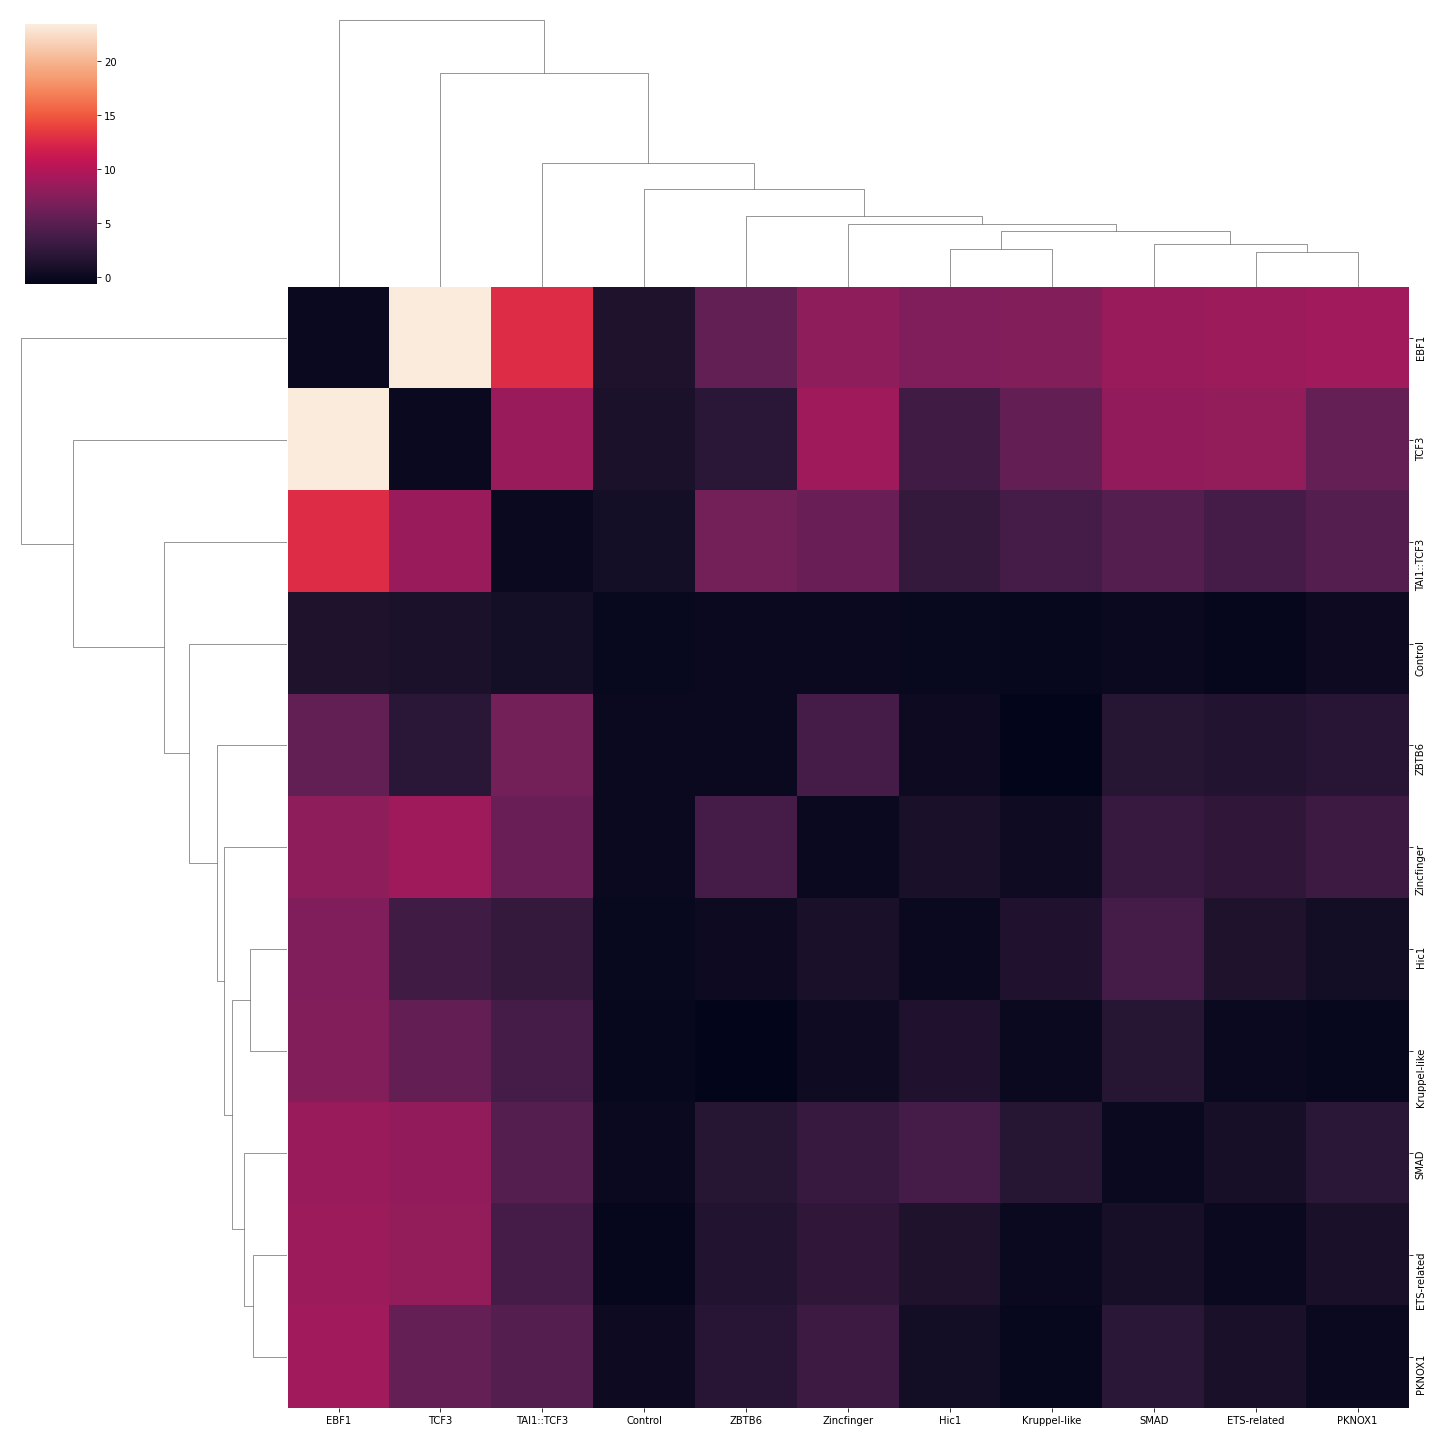

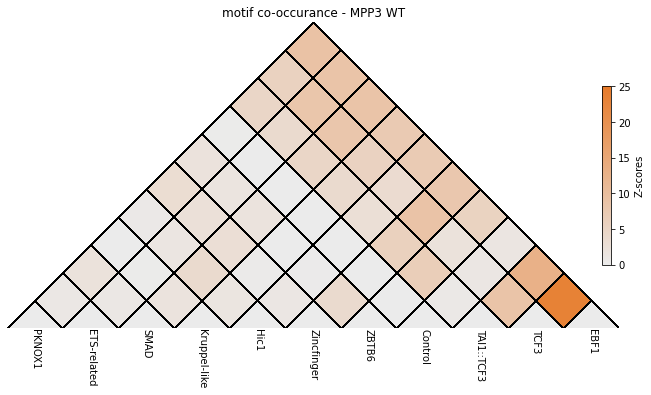

In [26]:
#MPP3WT [EBF_AL env]

MPP3WT_comot = pd.read_csv("../../data/ATAC/coMotifEnrichment/MPP3WT_allMotsZscores.tsv",
                          sep='\t', index_col=0)
MPP3WT_comot = comotDFRenamer(MPP3WT_comot, motNameDic, 'MPP3WT')
# Collapse the controls with medians:
MPP3WT_comot = reducemotDF(MPP3WT_comot, 'MPP3WT')
# Filter those motifs if no interactions are above 2 (z-score):
ser = (MPP3WT_comot > 2).any(axis=1)
keepLis = list( ser[ser == True].index )
#Add the control in any case.
if 'Control' not in keepLis:
    keepLis.append('Control')

MPP3WT_comot_red = MPP3WT_comot[keepLis]
MPP3WT_comot_red = MPP3WT_comot_red.loc[keepLis,:]

# Get clusterorder.
g = sns.clustermap(MPP3WT_comot_red, figsize=(20,20), xticklabels=True, yticklabels=True)
rowClus = []
colClus = []
for index in g.dendrogram_row.reordered_ind:
    rowClus.append(MPP3WT_comot_red.index[index])
MPP3WT_comot_red = MPP3WT_comot_red.reindex( rowClus )

for index in g.dendrogram_col.reordered_ind:
    colClus.append(MPP3WT_comot_red.columns[index])
MPP3WT_comot_red = MPP3WT_comot_red.reindex(columns = colClus)

X, Y, C = retTriangCoords(MPP3WT_comot_red)
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211, frame_on=False, aspect=2.0)
ax.set_xticks([])
ax.set_yticks([])
g = plt.pcolormesh(X,Y,np.flip(C), axes=ax, edgecolors='black',linewidth=0.75,
                   cmap = cmapFromHexLis( ['#ECECEC', "#E87B2A"] ),
                   norm = mp.colors.TwoSlopeNorm(vmin=0, vcenter=12.5, vmax=25))
ax.set_ylim(bottom=5.5)
ax.set_title("motif co-occurance - MPP3 WT")
ax.set_axisbelow(True)
plt.colorbar(g, orientation='vertical', shrink=0.5825,
             fraction=0.05, pad=-0.025, use_gridspec=True, label="Z-scores"
            )
fig.subplots_adjust(wspace=-0.12, hspace=0, left=0, right=1)
for i in list(range(-10,11,2)):
    plt.text(i, 5.5, list(MPP3WT_comot_red.index)[::-1][int( (i+10)/2 )] ,
             rotation=-90, va='top',ha='center')
plt.tight_layout()
plt.savefig("../../figures/MPP3WT_comots.svg", dpi=300)

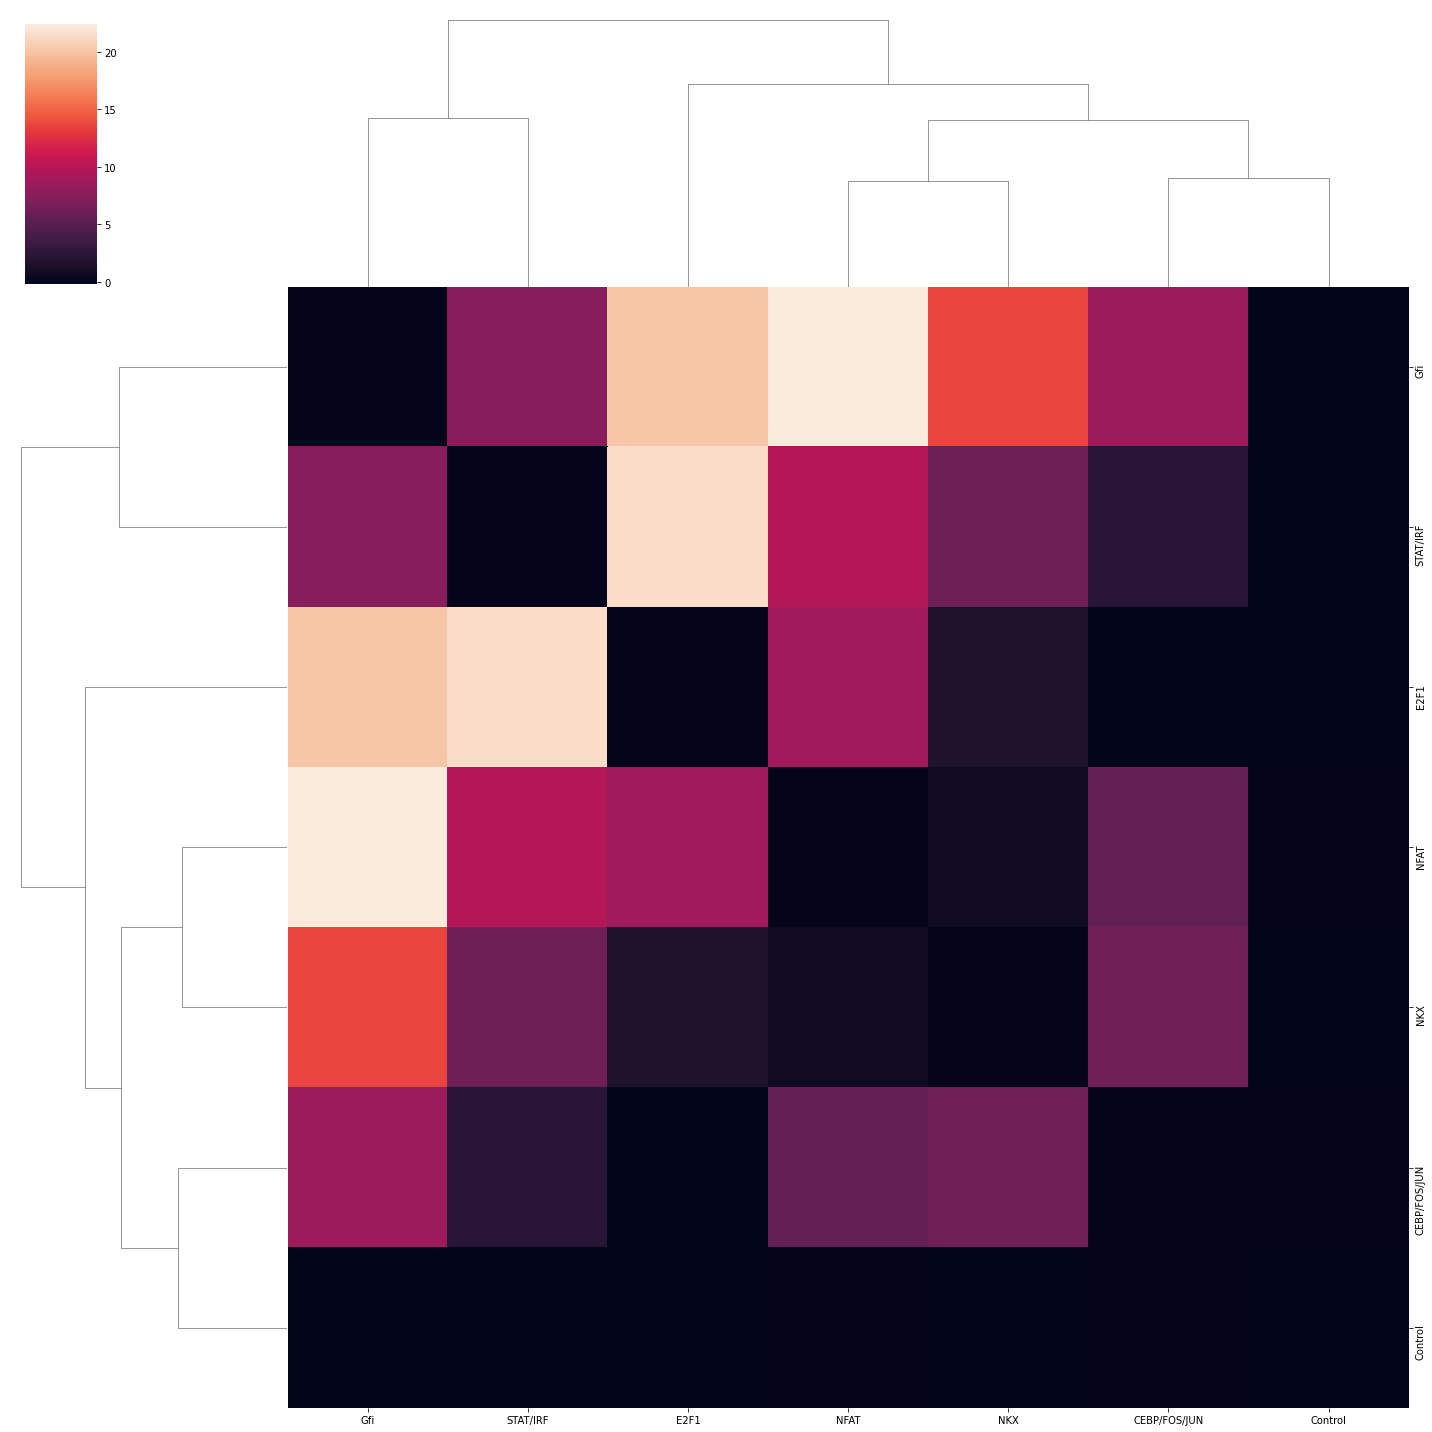

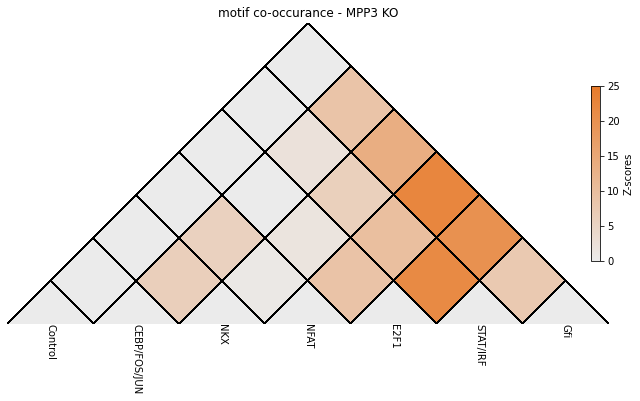

In [25]:
# MPP3 KO [EBF_AL env]

MPP3KO_comot = pd.read_csv("../../data/ATAC/coMotifEnrichment/MPP3KO_allMotsZscores.tsv",
                          sep='\t', index_col=0)
MPP3KO_comot = comotDFRenamer(MPP3KO_comot, motNameDic, 'MPP3KO')
# Collapse the controls with medians:
MPP3KO_comot = reducemotDF(MPP3KO_comot, 'MPP3KO')
# Filter those motifs if no interactions are above 2 (z-score):

ser = (MPP3KO_comot > 2).any(axis=1)
keepLis = list( ser[ser == True].index )
#Add the control in any case.
if 'Control' not in keepLis:
    keepLis.append('Control')

MPP3KO_comot_red = MPP3KO_comot[keepLis]
MPP3KO_comot_red = MPP3KO_comot_red.loc[keepLis,:]

# Get clusterorder.
g = sns.clustermap(MPP3KO_comot_red, figsize=(20,20), xticklabels=True, yticklabels=True)
rowClus = []
colClus = []
for index in g.dendrogram_row.reordered_ind:
    rowClus.append(MPP3KO_comot_red.index[index])
MPP3KO_comot_red = MPP3KO_comot_red.reindex( rowClus )

for index in g.dendrogram_col.reordered_ind:
    colClus.append(MPP3KO_comot_red.columns[index])
MPP3KO_comot_red = MPP3KO_comot_red.reindex(columns = colClus)


X, Y, C = retTriangCoords(MPP3KO_comot_red)
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211, frame_on=False, aspect=2.0)
ax.set_xticks([])
ax.set_yticks([])
g = plt.pcolormesh(X,Y,np.flip(C), axes=ax, edgecolors='black',linewidth=0.75,
                   cmap = cmapFromHexLis( ['#ECECEC', "#E87B2A"] ),
                   norm = mp.colors.TwoSlopeNorm(vmin=0, vcenter=12.5, vmax=25))
ax.set_ylim(bottom=3.5)
#ax.set_xlim(-21,21)
ax.set_title("motif co-occurance - MPP3 KO")
ax.set_axisbelow(True)
plt.colorbar(g, orientation='vertical', shrink=0.5825,
             fraction=0.05, pad=-0.025, use_gridspec=True, label="Z-scores"
            )
fig.subplots_adjust(wspace=-0.12, hspace=0, left=0, right=1)
for i in list(range(-6,7,2)):
    plt.text(i, 3.5, list(MPP3KO_comot_red.index)[::-1][int( (i+6)/2 )] ,
             rotation=-90, va='top',ha='center')
plt.tight_layout()
plt.savefig("../../figures/MPP3KO_comots.svg", dpi=300)

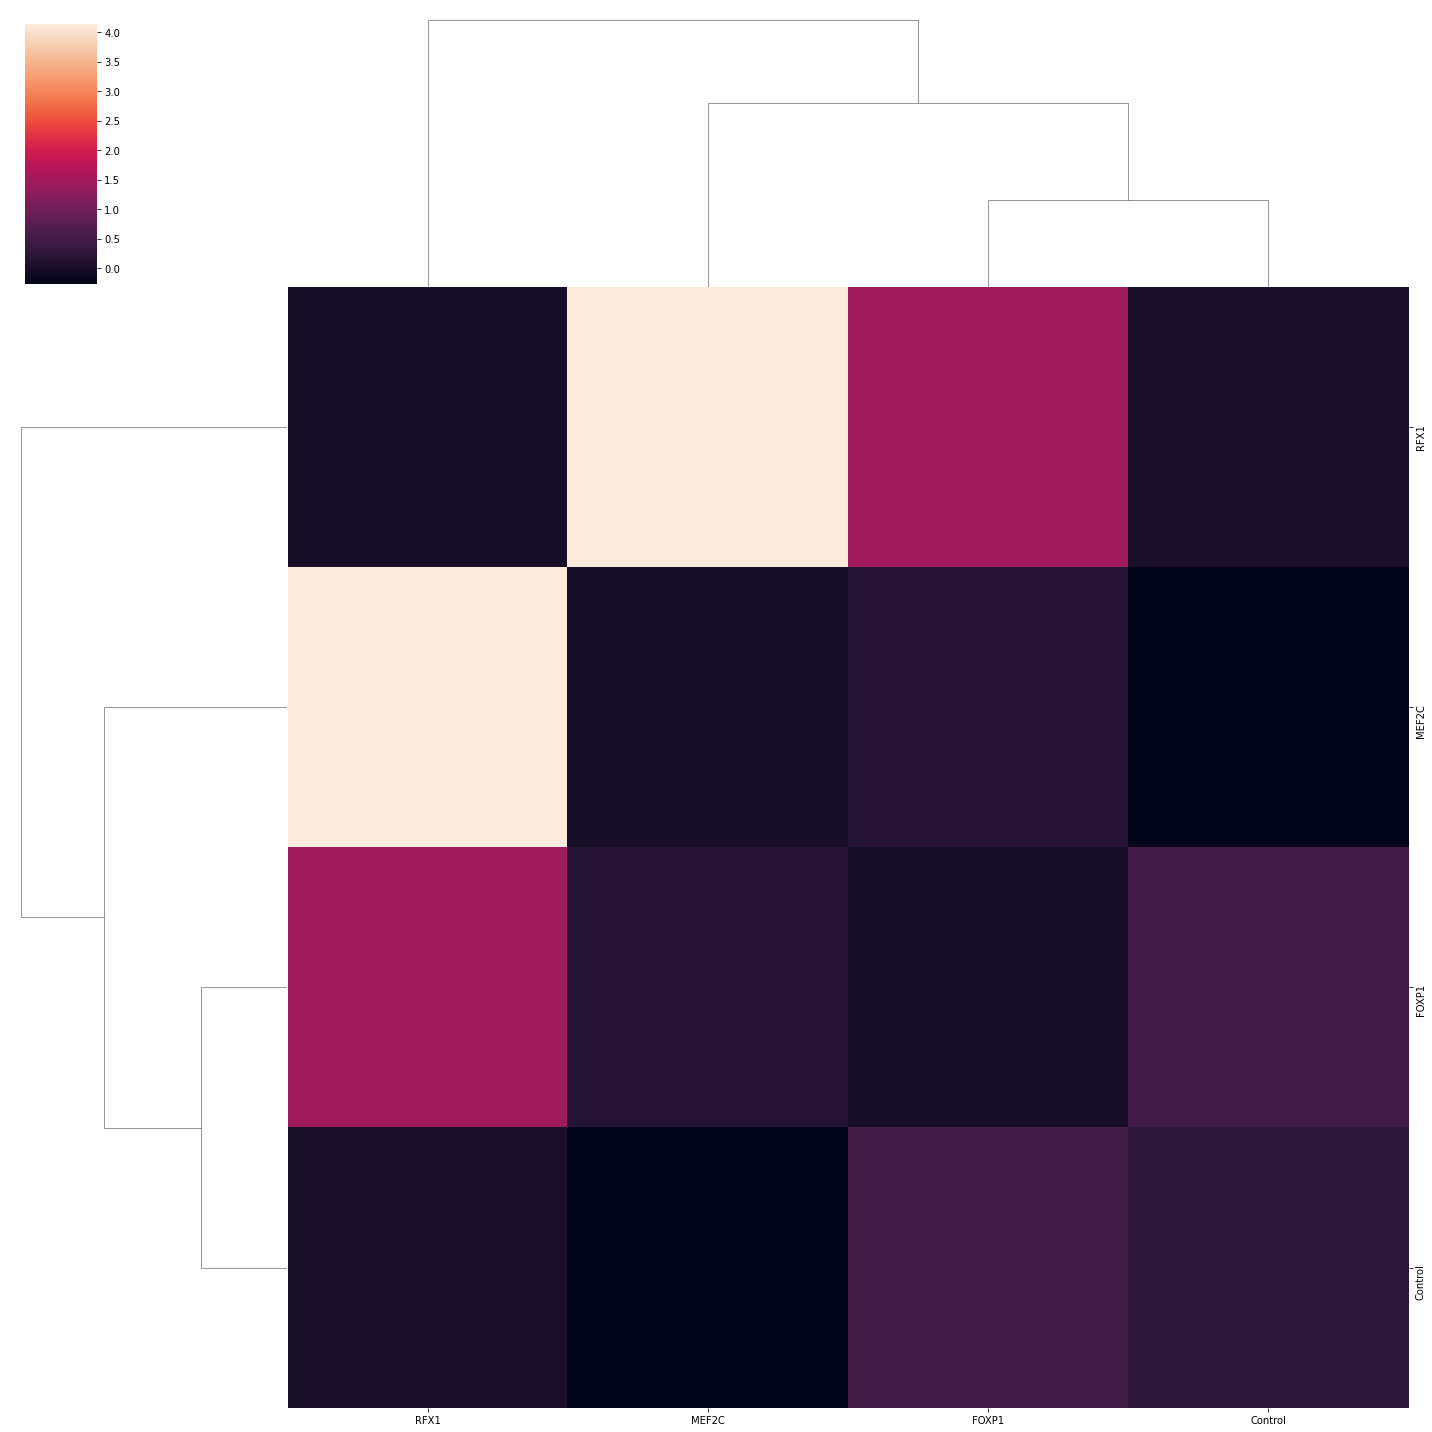

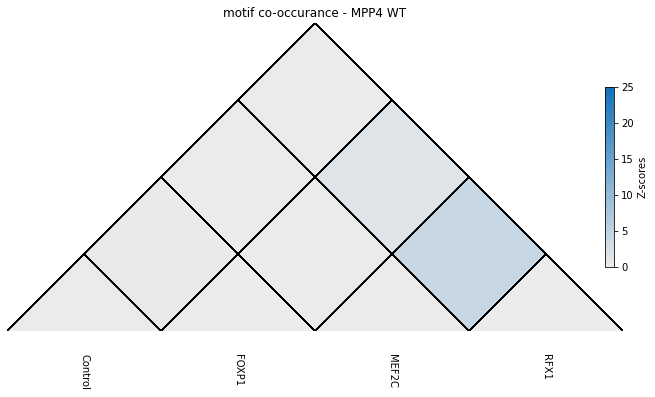

In [24]:
# MPP4 WT [EBF_AL env]

MPP4WT_comot = pd.read_csv("../../data/ATAC/coMotifEnrichment/MPP3WT_allMotsZscores.tsv",
                          sep='\t', index_col=0)
MPP4WT_comot = comotDFRenamer(MPP4WT_comot, motNameDic, 'MPP4WT')

# Collapse the controls with medians:
MPP4WT_comot = reducemotDF(MPP4WT_comot, 'MPP4WT')
# Filter those motifs if no interactions are above 2 (z-score):

ser = (MPP4WT_comot > 2).any(axis=1)
keepLis = list( ser[ser == True].index )
#Add the control in any case.
if 'Control' not in keepLis:
    keepLis.append('Control')

#! Foxp3 and Foxp1 clusters are very similar
# They are missed in the clustering round because in round 1 Foxp3 has 4 additional positions.
if 'FOXP3' in keepLis:
    keepLis.remove("FOXP3")
    
MPP4WT_comot_red = MPP4WT_comot[keepLis]
MPP4WT_comot_red = MPP4WT_comot_red.loc[keepLis,:]

# Get clusterorder.
g = sns.clustermap(MPP4WT_comot_red, figsize=(20,20), xticklabels=True, yticklabels=True)
rowClus = []
colClus = []
for index in g.dendrogram_row.reordered_ind:
    rowClus.append(MPP4WT_comot_red.index[index])
MPP4WT_comot_red = MPP4WT_comot_red.reindex( rowClus )

for index in g.dendrogram_col.reordered_ind:
    colClus.append(MPP4WT_comot_red.columns[index])
MPP4WT_comot_red = MPP4WT_comot_red.reindex(columns = colClus)


X, Y, C = retTriangCoords(MPP4WT_comot_red)
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211, frame_on=False, aspect=2.0)
ax.set_xticks(range(-20,20,1))
ax.set_yticks([])
ax.set_xticks([])
g = plt.pcolormesh(X,Y,np.flip(C), axes=ax, edgecolors='black',linewidth=0.75,
                   cmap = cmapFromHexLis( ['#ECECEC', "#1272BA"] ),
                   norm = mp.colors.TwoSlopeNorm(vmin=0, vcenter=12.5, vmax=25))
ax.set_ylim(bottom=2)
ax.set_title("motif co-occurance - MPP4 WT")
ax.set_axisbelow(True)
plt.colorbar(g, orientation='vertical', shrink=0.5825,
             fraction=0.05, pad=-0.025, use_gridspec=True, label="Z-scores"
            )
fig.subplots_adjust(wspace=-0.12, hspace=0, left=0, right=1)
for i in list(range(-3,4,2)):
    plt.text(i, 1.85, list(MPP4WT_comot_red.index)[::-1][int( (i+3)/2 )] ,
             rotation=-90, va='top',ha='center')
plt.tight_layout()
plt.savefig("../../figures/MPP4WT_comots.svg", dpi=300)

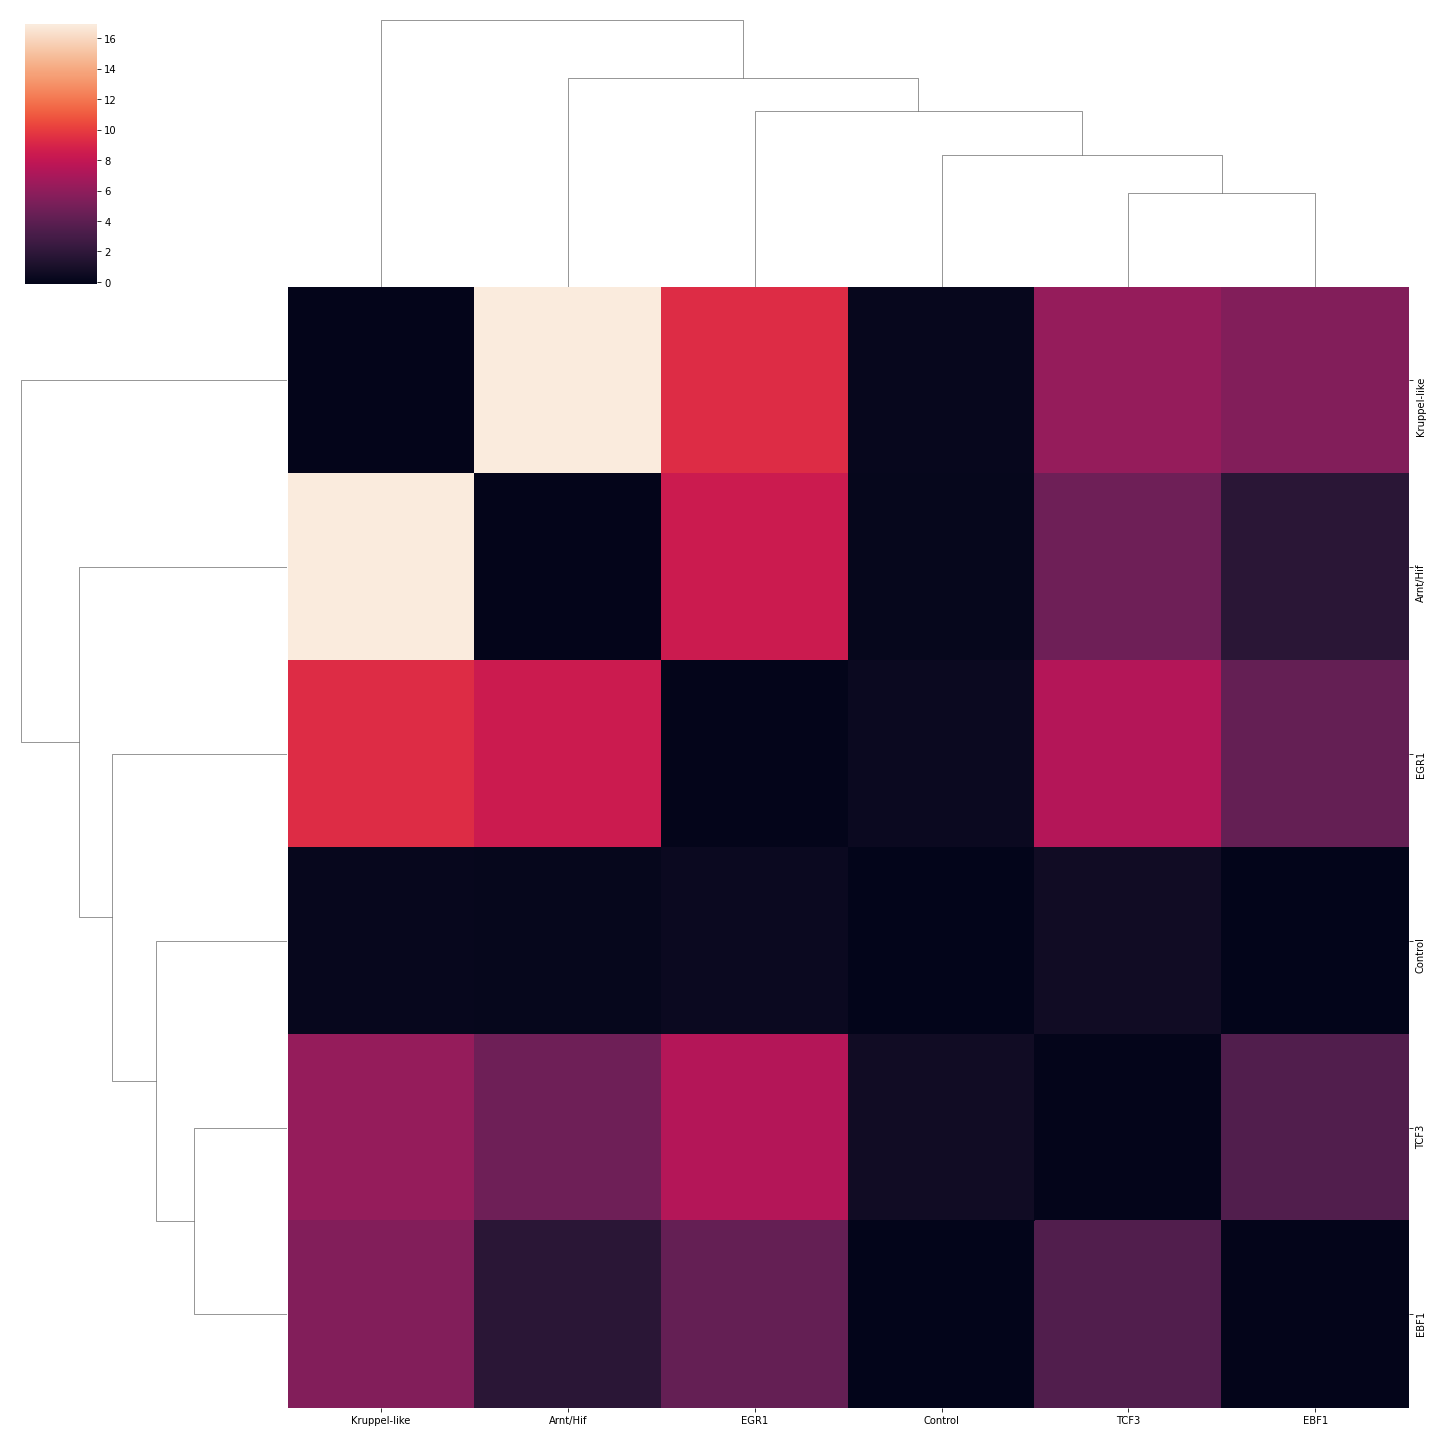

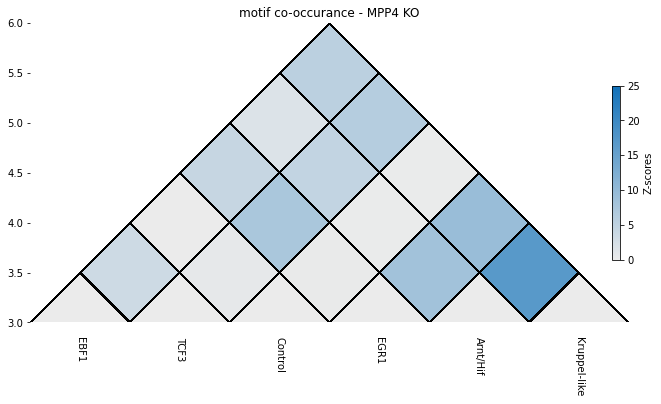

In [23]:
# MPP4 KO [EBF_AL env]

MPP4KO_comot = pd.read_csv("../../data/ATAC/coMotifEnrichment/MPP4KO_allMotsZscores.tsv",
                          sep='\t', index_col=0)
MPP4KO_comot = comotDFRenamer(MPP4KO_comot, motNameDic, 'MPP4KO')
# Collapse the controls with medians:
MPP4KO_comot = reducemotDF(MPP4KO_comot, 'MPP4KO')

# Filter those motifs if no interactions are above 2 (z-score):

ser = (MPP4KO_comot > 2).any(axis=1)
keepLis = list( ser[ser == True].index )
#Add the control in any case.
if 'Control' not in keepLis:
    keepLis.append('Control')
    
MPP4KO_comot_red = MPP4KO_comot[keepLis]
MPP4KO_comot_red = MPP4KO_comot_red.loc[keepLis,:]

# Get clusterorder.
g = sns.clustermap(MPP4KO_comot_red, figsize=(20,20), xticklabels=True, yticklabels=True)
rowClus = []
colClus = []
for index in g.dendrogram_row.reordered_ind:
    rowClus.append(MPP4KO_comot_red.index[index])
MPP4KO_comot_red = MPP4KO_comot_red.reindex( rowClus )

for index in g.dendrogram_col.reordered_ind:
    colClus.append(MPP4KO_comot_red.columns[index])
MPP4KO_comot_red = MPP4KO_comot_red.reindex(columns = colClus)

X, Y, C = retTriangCoords(MPP4KO_comot_red)
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211, frame_on=False, aspect=2.0)
ax.set_xticks(range(-20,20,1))
#ax.set_yticks([])
ax.set_xticks([])
g = plt.pcolormesh(X,Y,np.flip(C), axes=ax, edgecolors='black',linewidth=0.75,
                   cmap = cmapFromHexLis( ['#ECECEC', "#1272BA"] ),
                   norm = mp.colors.TwoSlopeNorm(vmin=0, vcenter=12.5, vmax=25))
ax.set_ylim(bottom=3)
#ax.set_xlim(-7,7)
ax.set_title("motif co-occurance - MPP4 KO")
ax.set_axisbelow(True)
plt.colorbar(g, orientation='vertical', shrink=0.5825,
             fraction=0.05, pad=-0.025, use_gridspec=True, label="Z-scores"
            )

fig.subplots_adjust(wspace=-0.12, hspace=0, left=0, right=1)
for i in list(range(-5,6,2)):
    plt.text(i, 2.85, list(MPP4KO_comot_red.index)[::-1][int( (i+5)/2 )] ,
             rotation=-90, va='top',ha='center')
plt.tight_layout()
plt.savefig("../../figures/MPP4KO_comots.svg", dpi=300)

In [109]:
# MPP3 and MPP4 specific motifs. [EBF_AL env]

# a new dictionary to rename, since we have other clusters now.

motNameDic = {
'Cluster_41 Ahr::Arnt,EOMES,MGA,TBR1(...)':['T-box factors','MPP3 MPP4'],
 'Cluster_40 Arnt,ARNT2,Arntl(...),ARNT::HIF1A,HES1,HES2(...),Creb3l2,CREB3L4':['SREBF2','MPP3'],
 'Cluster_47 BHLHE22(var.2),SNAI1,Tcf12(...),ASCL1,Ascl2,BHLHA15(var.2)(...),GRHL2,SCRT1,SCRT2':["TCF3","MPP3 MPP4"],
 'Cluster_37 CEBPA,CEBPB,CEBPD(...),CREB1':["CEBP","MPP3"],
 'Cluster_67 CTCFL,Plagl1,PLAGL2,CTCF':['CTCF','MPP3 MPP4'],
 'MPP3_MA1480.1 DPRX':["DPRX",'MPP3'],
 'MPP3_Cluster_35 E2F1,E2F2,E2F4(...)':["E2F","MPP3"],
 'Cluster_61 E2F6,KLF15,TFDP1,MAZ,ZNF148,ZNF263':["MAX/TFDP1","MPP3"],
 'Cluster_69 EBF1,Ebf2,EBF3,TFAP2A,TFAP2A(var.2),TFAP2B(...)':["Ebf","MPP3"],
 'Cluster_60 EGR1,EGR2,EGR3(...),Wt1,Znf281,ZNF740':["EGR1","MPP3"],
 'Cluster_26 ELF2,ELK1,ELK3(...),EHF,ELF1,ELF3(...),SPI1,SPIB,ZKSCAN5(...)':["ELF/ETS","MPP3 MPP4"],
 'Cluster_15 FOXG1,FOXI1,FOXL1(...),FOXA1,FOXA2,FOXA3(...),FOXP3':["FOX","MPP3 MPP4"],
 'MPP3_Cluster_4 GATA1,GATA1::TAL1,GATA2(...)':["GATA","MPP3"],
 'MPP3_Cluster_31 GLIS2,ZIC3,ZIC4':["GLIS2","MPP3"],
 'Cluster_56 HIC2,THAP1,Hic1,NFIA,NFIC':["NFI/THAP","MPP3 MPP4"],
 'Cluster_64 HINFP,ZBTB14,NRF1':["HINFP/ZBTB14/NRF1","MPP3"],
 'Cluster_59 Klf1,Klf12,KLF2(...),KLF10,KLF11,KLF13(...),ZNF682':["KLF","MPP3"],
 'Cluster_5 MSANTD3,ISL2,MSANTD3,NKX2-2(...)':["MSANTD3","MPP3 MPP4"],
 'MPP3_Cluster_18 MYB,OVOL2':["MYB","MPP3"],   
 'Cluster_4 NFYA,NFYB,NFYC,GFI1,Gfi1b':["GFI1/NFY","MPP3 MPP4"],
 'Cluster_36 NR2C1,NR2C2(var.2),NR1I3,VDR,Nr2e1,NR4A1(...)':["NR","MPP3 MPP4"],
 'MPP3_Cluster_16 PAX1,PAX5,PAX9':["PAX1/5/9", "MPP3"],
 'Cluster_38 Pax2,Pax2':["PAX2", "MPP3 MPP4"],
 'MPP3_MA0163.1 PLAG1':["PLAG1", "MPP3"],
 'Cluster_12 POU3F4,POU5F1B,POU2F1,POU3F1,POU3F3(...)':["POU-factors", "MPP3 MPP4"],
 'Cluster_54 RBPJ,NFAT5,NFATC1,NFATC2(...)':["NFAT", "MPP3 MPP4"],
 'MPP3_Cluster_22 REL,RELA':["REL", "MPP3"],
 'MPP3_MA1563.1 SOX18':["SOX18","MPP3"],
 'MPP3_Cluster_24 TFAP2A(var.3),TFAP2B(var.3),TFAP2C(var.3)':["TFAP2","MPP3"],
 'MPP3_MA1573.1 THAP11':["THAP11","MPP3"],
 'MPP3_Cluster_13 YY1,YY2,ZFP42':["YY","MPP3"],
 'MPP3_MA0527.1 ZBTB33':["ZBTB33","MPP3"],
 'MPP3_MA1583.1 ZFP57':["ZFP57","MPP3"],
 'MPP3_Cluster_38 Zfx,ZNF460':["Zfx","MPP3"],
 'Cluster_17 ALX3,ARGFX,Dlx2(...),BARHL2,Dlx1,ESX1(...),BARX1,EMX1,EMX2(...)(...)':["Homeobox 1","MPP4"],
 'Cluster_9 Arid3a,Arid3b,TBP,MEF2A,MEF2B,MEF2C(...),ZNF384':["Arid3/MEF", "MPP4"],
 'MPP4_MA0602.1 Arid5a':["Arid5a","MPP4"],
 'Cluster_48 Atoh1,ATOH1(var.2),Bhlha15(...),ATOH7,BHLHE22,BHLHE23(...)':["TAL::TCF3","MPP4"],
 'MPP4_Cluster_36 BACH1,BATF,BATF::JUN(...)':["FOS/JUN","MPP4"],
 'MPP4_Cluster_27 BARX2,HNF1A':["BARX2/HNF1A","MPP4"],
 'Cluster_55 BCL6,STAT1,STAT3(...),Stat6':["STAT","MPP4"],
 'Cluster_19 CDX1,CDX2,CDX4(...),Hoxa11,HOXA9,HOXB9(...)':["Homeobox 2","MPP4"],
 'MPP4_Cluster_7 Dmrt1,DMRT3,DMRTA2(...)':["DMRT","MPP4"],
 'Cluster_1 DUX4,PHOX2A,PHOX2B(...),Lhx3':["PHOX","MPP4"],
 'MPP4_MA0041.1 Foxd3':["Foxd3","MPP4"],
 'Cluster_50 Hand1::Tcf3,Smad4,HSF2,HSF4,ZBTB12':["Hand1::Tcf3","MPP4"],
 'MPP4_MA0109.1 HLTF':["HLTF","MPP4"],
 'MPP4_Cluster_66 HMBOX1,ZNF652':["HMBOX1","MPP4"],
 'MPP4_Cluster_68 IRF1,IRF2,IRF3(...)':["IRF","MPP4"],
 'MPP4_MA0619.1 LIN54':["LIN54","MPP4"],
 'Cluster_45 MAF,Mafb,MAFF,MAFG(...)':["MAF","MPP4"],
 'Cluster_30 MEIS1,MEIS2,MEIS3(...),SMAD2::SMAD3::SMAD4':["MEIS/SMAD","MPP4"],
 'Cluster_20 MEIS1(var.2),MEIS2(var.2),PBX1(...),ONECUT1,ONECUT2,ONECUT3':["MEIS/PBX","MPP4"],
 'Cluster_21 MYB,ZKSCAN1,OSR1,OSR2':["MYB/ZKSCAN1","MPP4"],
 'MPP4_MA0164.1 Nr2e3':["Nr2e3","MPP4"],
 'MPP4_Cluster_46 PKNOX2,TGIF2,TGIF2LX(...)':["TGIF2","MPP4"],
 'MPP4_Cluster_29 POU4F1,POU4F3':["POU4-factors","MPP4"],
 'MPP4_MA0508.3 PRDM1':["PRDM1","MPP4"],
 'MPP4_MA1647.1 PRDM4':["PRDM4","MPP4"],
 'MPP4_Cluster_64 RFX1,RFX2,RFX3(...)':["RFX","MPP4"],
 'MPP4_MA1554.1 RFX7':["RFX7","MPP4"],
 'MPP4_Cluster_8 Rhox11,ZBTB32':["Rhox11/ZBTB32","MPP4"],
 'MPP4_MA0073.1 RREB1':["RREB1","MPP4"],
 'Cluster_43 RUNX1,RUNX2,RUNX3,ZNF354C':["RUNX","MPP4"],
 'MPP4_Cluster_4 SIX1,SIX2':["SIX","MPP4"],
 'Cluster_23 SOX10,SOX13,SOX15(...),SOX12,Sox5,SOX9(...)':["SOX","MPP4"],
 'MPP4_MA0111.1 Spz1':["Spz1","MPP4"],
 'MPP4_Cluster_9 TCF7,TCF7L1,TCF7L2':["TCF7","MPP4"],
 'MPP4_Cluster_44 TEAD1,TEAD2,TEAD3(...)':["TEAD","MPP4"],
 'MPP4_MA1589.1 ZNF140':["ZNF140","MPP4"],
 'MPP4_MA1124.1 ZNF24':["ZNF24","MPP4"],
}


# Create function to rename column and index in Zscore DF's.
def comotDFRenamer(df, renameDic, cond):
    renameLis = []
    for cluster in df.columns:
        if cond in renameDic[cluster][1]:
            renameLis.append(renameDic[cluster][0])
        else:
            renameLis.append( 'control_' + renameDic[cluster][0] )
    df.columns = renameLis
    renameLis = []
    for cluster in df.index:
        if cond in renameDic[cluster][1]:
            renameLis.append(renameDic[cluster][0])
        else:
            renameLis.append( 'control_' + renameDic[cluster][0] )
    df.index = renameLis
    return df


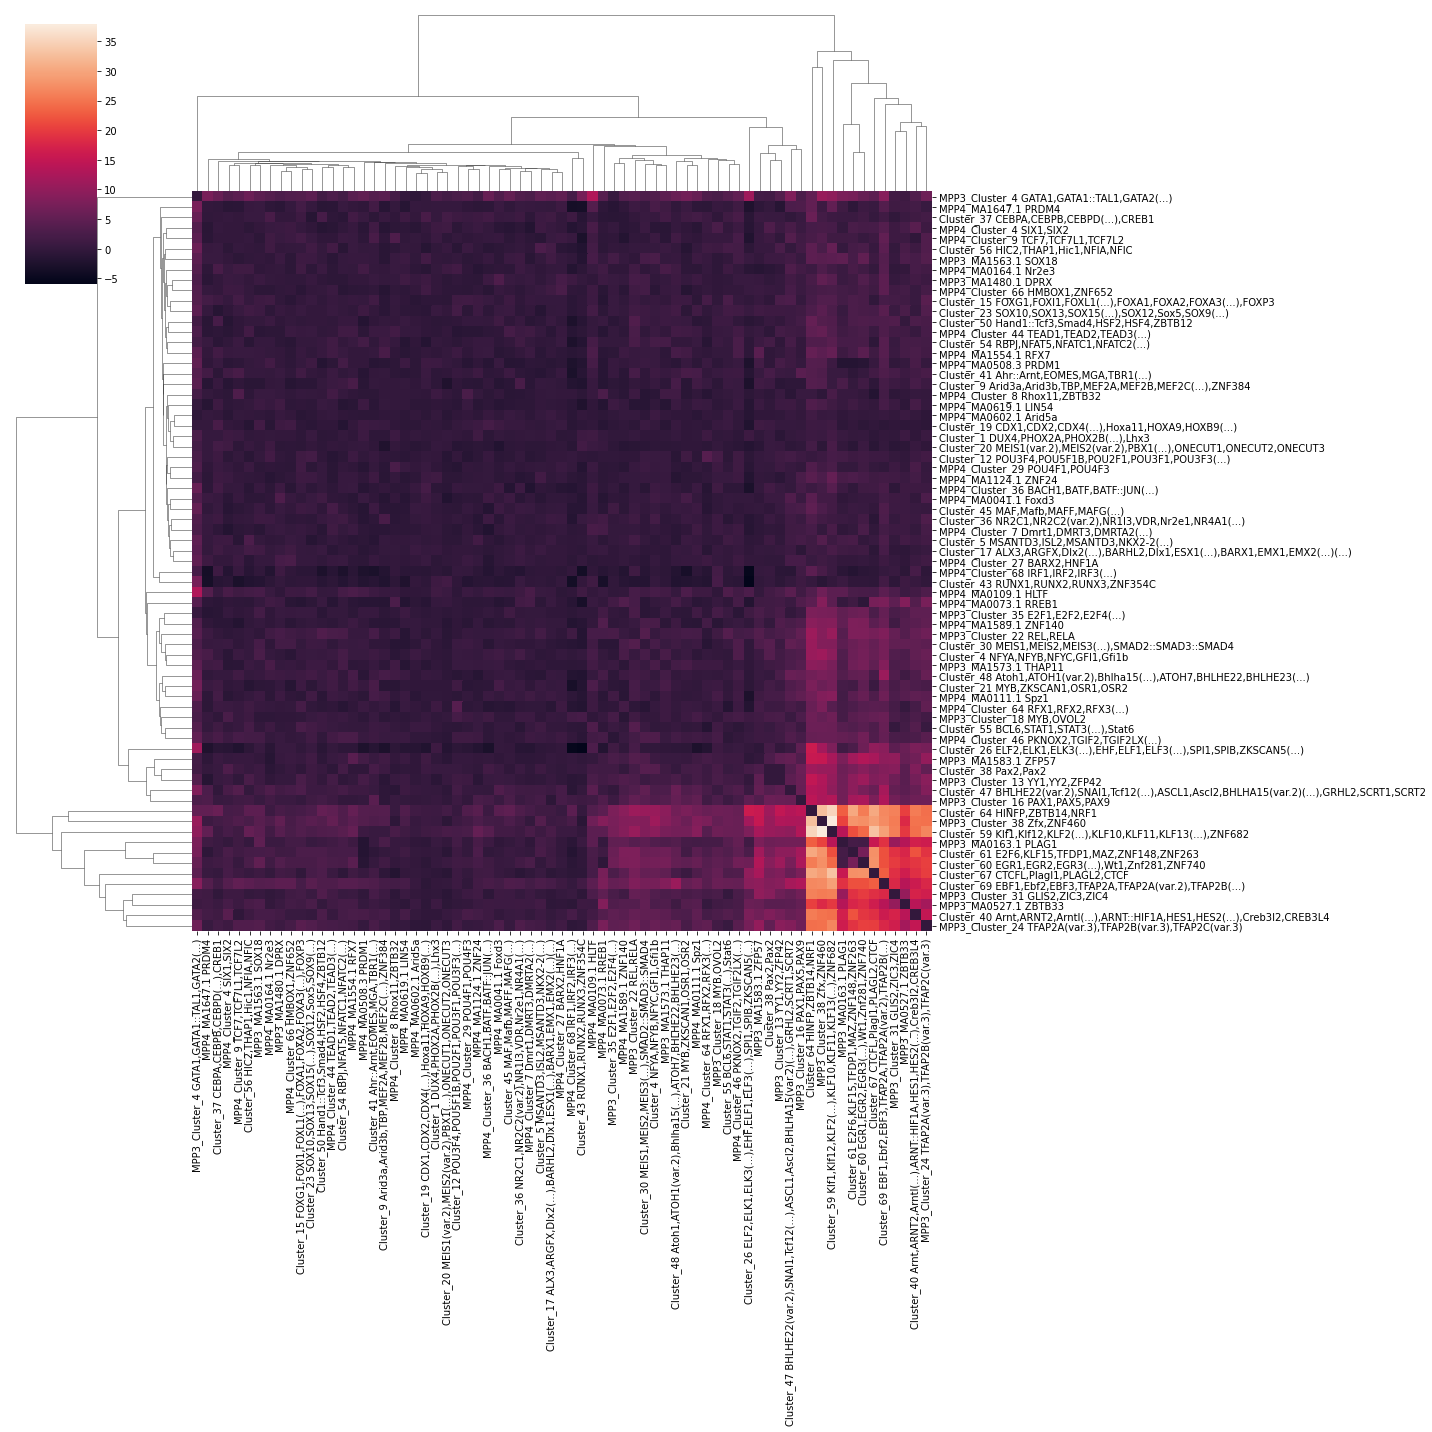

In [110]:
# MPP3

MPP3_comot = pd.read_csv("../../data/ATAC_mpp3vmpp4/coMotifEnrichment/MPP3_Zscores.tsv",
                          sep='\t', index_col=0)
# Reorder based on seaborn clustering.

g = sns.clustermap(MPP3_comot, figsize=(20,20), xticklabels=True, yticklabels=True)
rowClus = []
colClus = []

for index in g.dendrogram_row.reordered_ind:
    rowClus.append(MPP3_comot.index[index])
MPP3_comot = MPP3_comot.reindex( rowClus )

for index in g.dendrogram_col.reordered_ind:
    colClus.append(MPP3_comot.columns[index])
MPP3_comot = MPP3_comot.reindex(columns = colClus)
MPP3_comot = comotDFRenamer(MPP3_comot, motNameDic, 'MPP3')
# Collapse the controls with medians:
MPP3_comot = reducemotDF(MPP3_comot, 'MPP4')

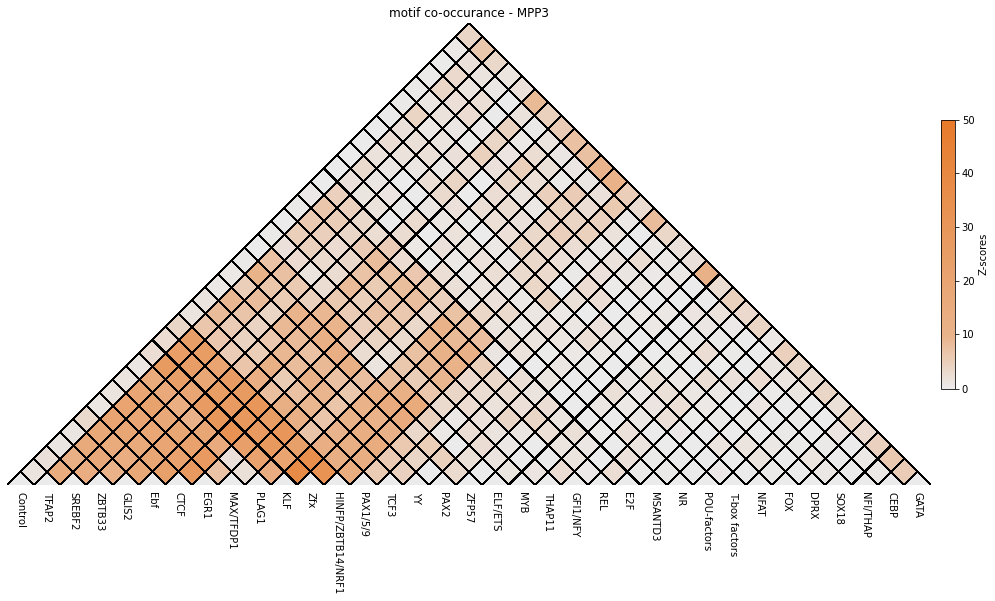

In [117]:
# Filter those motifs if no interactions are above 2 (z-score): [EBF_AL env]

ser = (MPP3_comot > 2).any(axis=1)
keepLis = list( ser[ser == True].index )
#Add the control in any case.
if 'Control' not in keepLis:
    keepLis.append('Control')
MPP3_comot_red = MPP3_comot[keepLis]
MPP3_comot_red = MPP3_comot_red.loc[keepLis,:]


X, Y, C = retTriangCoords(MPP3_comot_red)
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(211, frame_on=False, aspect=2.0)
ax.set_xticks(range(-34,34,2))
ax.set_yticks([])
ax.set_xticks([])
g = plt.pcolormesh(X,Y,np.flip(C), axes=ax, edgecolors='black',linewidth=0.75,
                   cmap = cmapFromHexLis( ['#ECECEC', "#E87B2A"] ),
                   norm = mp.colors.TwoSlopeNorm(vmin=0, vcenter=10, vmax=50))
ax.set_ylim(bottom=17.5)
#ax.set_xlim(-7,7)
ax.set_title("motif co-occurance - MPP3")
ax.set_axisbelow(True)
plt.colorbar(g, orientation='vertical', shrink=0.5825,
             fraction=0.05, pad=0.01, use_gridspec=True, label="Z-scores"
            )
fig.subplots_adjust(wspace=-0.12, hspace=0, left=0, right=1)
for i in list(range(-34,35,2)):
    plt.text(i, 17.25, list(MPP3_comot_red.index)[::-1][int( (i+34)/2 )] ,
             rotation=-90, va='top',ha='center')
plt.tight_layout()
plt.savefig("../../figures/MPP3_comots.svg", dpi=300)

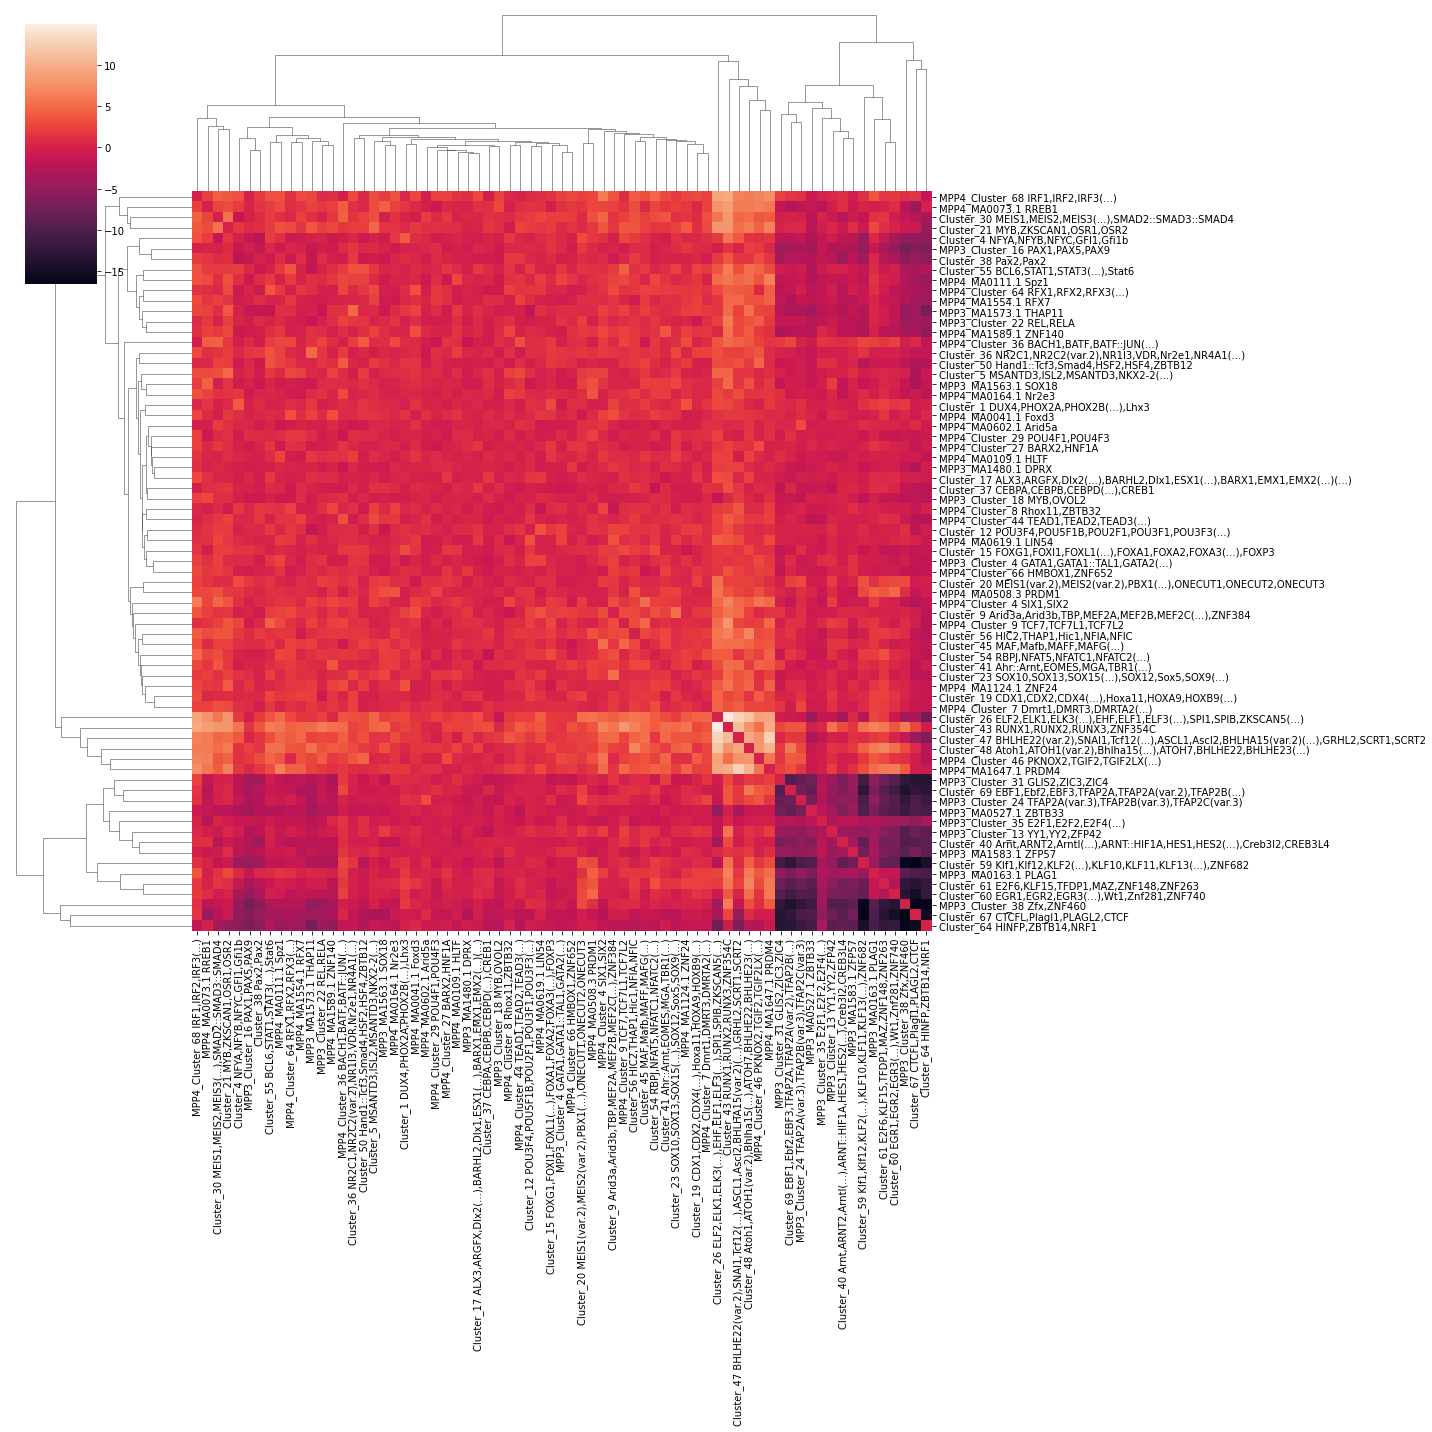

In [118]:
# MPP4 [EBF_AL env]

MPP4_comot = pd.read_csv("../../data/ATAC_mpp3vmpp4/coMotifEnrichment/MPP4_Zscores.tsv",
                          sep='\t', index_col=0)
# Reorder based on seaborn clustering.

g = sns.clustermap(MPP4_comot, figsize=(20,20), xticklabels=True, yticklabels=True)
rowClus = []
colClus = []

for index in g.dendrogram_row.reordered_ind:
    rowClus.append(MPP4_comot.index[index])
MPP4_comot = MPP4_comot.reindex( rowClus )

for index in g.dendrogram_col.reordered_ind:
    colClus.append(MPP4_comot.columns[index])
MPP4_comot = MPP4_comot.reindex(columns = colClus)
MPP4_comot = comotDFRenamer(MPP4_comot, motNameDic, 'MPP4')
# Collapse the controls with medians:
MPP4_comot = reducemotDF(MPP4_comot, 'MPP3')

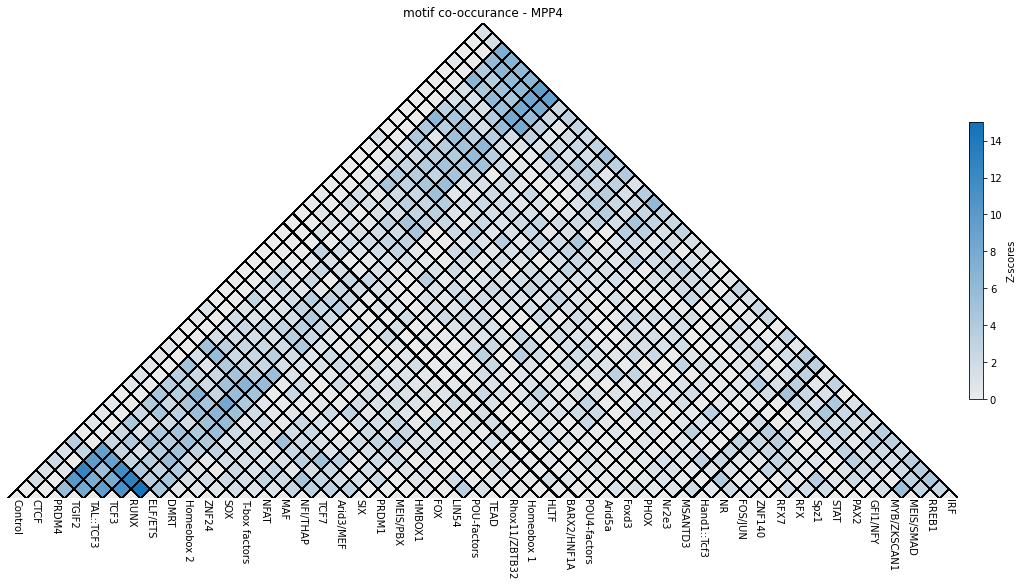

In [120]:
#Add the control in any case. [EBF_AL env]
ser = (MPP4_comot > 2).any(axis=1)
keepLis = list( ser[ser == True].index )
if 'Control' not in keepLis:
    keepLis.append('Control')
MPP4_comot_red = MPP4_comot[keepLis]
MPP4_comot_red = MPP4_comot_red.loc[keepLis,:]

X, Y, C = retTriangCoords(MPP4_comot_red)
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(211, frame_on=False, aspect=2.0)
#ax.set_xticks(range(-50,50,2))
ax.set_yticks([])
ax.set_xticks([])
g = plt.pcolormesh(X,Y,np.flip(C), axes=ax, edgecolors='black',linewidth=0.75,
                   cmap = cmapFromHexLis( ['#ECECEC', "#1272BA"] ),
                   norm = mp.colors.TwoSlopeNorm(vmin=0, vcenter=7.5, vmax=15))
ax.set_ylim(bottom=25)
#ax.set_xlim(-7,7)
ax.set_title("motif co-occurance - MPP4")
ax.set_axisbelow(True)
plt.colorbar(g, orientation='vertical', shrink=0.5825,
             fraction=0.05, pad=0.01, use_gridspec=True, label="Z-scores"
            )
fig.subplots_adjust(wspace=-0.12, hspace=0, left=0, right=1)
for i in list(range(-50,50,2)):
    plt.text(i+1, 25, list(MPP4_comot_red.index)[::-1][int( (i+50)/2 )] ,
             rotation=-90, va='top',ha='center')
plt.tight_layout()
plt.savefig("../../figures/MPP4_comots.svg", dpi=300)

### Aggregation plots.

EBF1 motif was enriched in MPP3 WT specific peaks. To have a look how the ATAC profiles look at those sites, we run tobias (https://github.com/loosolab/TOBIAS) and use the plotAggregate function.

run tobias workflow (set variables in first lines of script):
[TOBIASenv]
```bash
snakemake -s ../../scripts/FootPrinter.smk -j 10
```
[EBF_AL env]
run fimo on MPP3 WT-specific peaks for EBF motif.

For EBF1:

```bash
fimo --max-stored-scores 100000000 --o ../../data/ATAC/TOBIAS/EBF_MPP3WT ../../LFS/genomeData/singleMotifs/EBF1_MA0154.3.meme ../../data/ATAC/output/MPP3_WT.fna

python ../scripts/fimoCentral.py -i ../../data/ATAC/TOBIAS/EBF_MPP3WT/fimo.tsv -o ../../data/ATAC/TOBIAS/EBF_MPP3WT/ --cond EBF1hits_MPP3WT
```

[TOBIASenv]  
```bash
TOBIAS PlotAggregate --TFBS ../../data/ATAC/TOBIAS/EBF_MPP3WT/MA0154.3.EBF1hits_MPP3WT.bed --signals ../../LFS/TOBIAS/MPP3_WT_corrected.bw ../../LFS/TOBIAS/MPP3_KO_corrected.bw ../../LFS/TOBIAS/MPP4_WT_corrected.bw ../../LFS/TOBIAS/MPP4_KO_corrected.bw --output ../../data/ATAC/TOBIAS/EBFhitMPP3WT_aggPlot.pdf --output-txt ../../data/ATAC/TOBIAS/EBFhitMPP3WT_aggPlot.txt --share-y signals --signal-on-x --smooth 5 --plot-boundaries
```

[EBF_AL env]  

Look for CTCF sites.
```bash
fimo --max-stored-scores 100000000 --o ../../data/ATAC/TOBIAS/CTCF_MPP3 ../../LFS/genomeData/singleMotifs/CTCF_MA0139.1.meme ../../data/ATAC/output/MPP3_peaks.fna

python ../scripts/fimoCentral.py -i ../../data/ATAC/TOBIAS/CTCF_MPP3/fimo.tsv -o ../../data/ATAC/TOBIAS/CTCF_MPP3/ --cond CTCFhits_MPP3
```

Take random subset of all CTCF sites to have an equal number of sites as for EBF (336):

```bash
python ../scripts/randomBed.py -i ../../data/ATAC/TOBIAS/CTCF_MPP3/MA0139.1.CTCFhits_MPP3.bed -o ../../data/ATAC/TOBIAS/CTCF_MPP3/CTCFsites_subset -l 336 -n 100
```

[TOBIASenv]
```bash
TOBIAS PlotAggregate --TFBS ../../data/ATAC/TOBIAS/CTCF_MPP3/CTCFsites_subset/*bed --signals ../../LFS/TOBIAS/MPP3_WT_corrected.bw ../../LFS/TOBIAS/MPP3_KO_corrected.bw ../../LFS/TOBIAS/MPP4_WT_corrected.bw ../../LFS/TOBIAS/MPP4_KO_corrected.bw --output ../../data/ATAC/TOBIAS/CTCFhitMPP3subset_aggPlot.pdf --output-txt ../../data/ATAC/TOBIAS/CTCFhitMPP3subset_aggPlot.txt --share-y signals --signal-on-x --smooth 5 --plot-boundaries
```

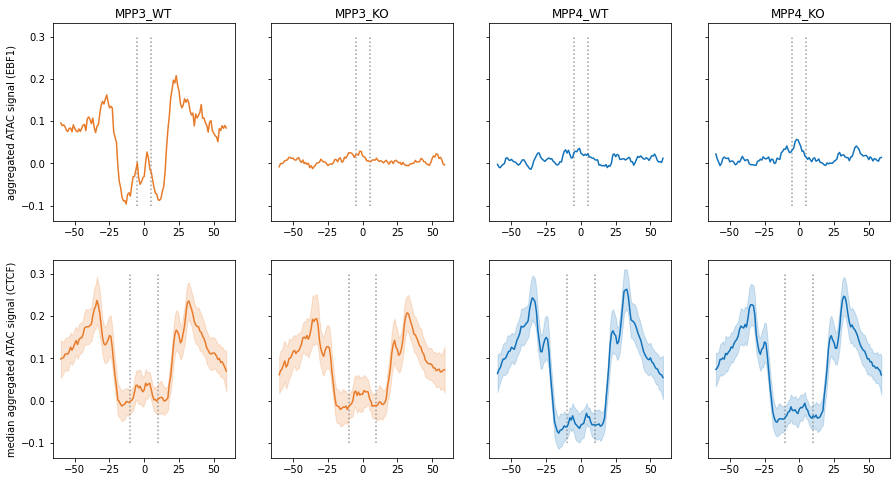

In [48]:
# Make aggregate plots. [EBF_AL env] 

CTCFdic = {}
# CTCF - for all subsampled beds we have a single line.
with open('../../data/ATAC/TOBIAS/CTCFhitMPP3subset_aggPlot.txt') as f:
    for line in f:
        if not line.startswith('#'):
            cond = line.strip().split()[0]
            measures = [ float(i) for i in line.strip().split()[2].split(',') ]
            if cond not in CTCFdic:
                CTCFdic[cond] = [measures]
            else:
                CTCFdic[cond].append(measures)

# Get median and sd
CTCFsumDic = {}
for cond in CTCFdic:
    CTCFsumDic[cond] = {}
    # Populate all bp ranges (Aggplots go from -60 to 60bp.)
    for i in range(-60,60,1):
        CTCFsumDic[cond][i] = []
    for array in CTCFdic[cond]:
        bpIx = -60
        for val in array:
            CTCFsumDic[cond][bpIx].append(val)
            bpIx += 1
CTCFsumDicMed = {}
for cond in CTCFsumDic:
    CTCFsumDicMed[cond] = {}
    for ix in CTCFsumDic[cond]:
        arr = np.array(CTCFsumDic[cond][ix])
        CTCFsumDicMed[cond][ix] = [ np.median( arr ),
                                    np.std( arr )
                                  ]

# Read EBF data.
EBFdic = {}
with open('../../data/ATAC/TOBIAS/EBFhitMPP3WT_aggPlot.txt') as f:
    for line in f:
        if not line.startswith('#'):
            cond = line.strip().split()[0]
            measures = [ float(i) for i in line.strip().split()[2].split(',') ]
            bpIndex = [i for i in range(-60,60,1)]
            EBFdic[cond] = [bpIndex, measures]

def aggPlotter_CTCF( medDic , col, cond, ylab=False, ax=None):
    ax = ax
    bpIndex = []
    median = []
    sdMin = []
    sdMax = []
    for idx in medDic:
        bpIndex.append(idx)
        median.append( medDic[idx][0] )
        sdMin.append( medDic[idx][0] -  medDic[idx][1] )
        sdMax.append( medDic[idx][0] +  medDic[idx][1] )
    ax.plot( bpIndex, median, color = col)
    ax.fill_between( bpIndex, sdMin, sdMax, color=col, alpha=0.2 )
    ax.vlines([-10,10],-0.1,0.3, linestyle=':', color='gray', alpha=0.8)
    return ax
   
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,8), sharey=True)

# Set Labels.
ax[0,0].title.set_text("MPP3_WT")
ax[0,1].title.set_text("MPP3_KO")
ax[0,2].title.set_text("MPP4_WT")
ax[0,3].title.set_text("MPP4_KO")
ax[0,0].set_ylabel("aggregated ATAC signal (EBF1)")
ax[1,0].set_ylabel("median aggregated ATAC signal (CTCF)")

# Plot EBF1.
ax[0,0].plot(EBFdic['MPP3_WT_corrected'][0], EBFdic['MPP3_WT_corrected'][1],
            color='#E87B2A')
ax[0,0].vlines([-5,5],-0.1,0.3, linestyle=':', color='gray', alpha=0.8)

ax[0,1].plot(EBFdic['MPP3_KO_corrected'][0], EBFdic['MPP3_KO_corrected'][1],
            color='#E87B2A')
ax[0,1].vlines([-5,5],-0.1,0.3, linestyle=':', color='gray', alpha=0.8)

ax[0,2].plot(EBFdic['MPP4_WT_corrected'][0], EBFdic['MPP4_WT_corrected'][1],
            color='#1272BA')
ax[0,2].vlines([-5,5],-0.1,0.3, linestyle=':', color='gray', alpha=0.8)

ax[0,3].plot(EBFdic['MPP4_KO_corrected'][0], EBFdic['MPP4_KO_corrected'][1],
            color='#1272BA')
ax[0,3].vlines([-5,5],-0.1,0.3, linestyle=':', color='gray', alpha=0.8)


# Plot CTCFs.
aggPlotter_CTCF( CTCFsumDicMed['MPP3_WT_corrected'], '#E87B2A', 'MPP3_WT', ylab=True, ax=ax[1,0] )

aggPlotter_CTCF( CTCFsumDicMed['MPP3_KO_corrected'], '#E87B2A', 'MPP3_KO', ylab=True, ax=ax[1,1] )
aggPlotter_CTCF( CTCFsumDicMed['MPP4_WT_corrected'], '#1272BA', 'MPP4_WT', ylab=True, ax=ax[1,2] )
aggPlotter_CTCF( CTCFsumDicMed['MPP4_KO_corrected'], '#1272BA', 'MPP4_KO', ylab=True, ax=ax[1,3] )

fig.savefig("../../figures/aggPlots_EBF_CTCF.svg", dpi=300)